# Description
## Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

## Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

## Data Dictionary

* CustomerId: Unique ID which is assigned to each customer
* Surname: Last name of the customer 
* CreditScore: It defines the credit history of the customer.  
* Geography: A customer’s location    
* Gender: It defines the Gender of the customer   
* Age: Age of the customer     
* Tenure: Number of years for which the customer has been with the bank
* NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
* Balance: Account balance
* HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
* EstimatedSalary: Estimated salary 
* isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
* Excited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )

In [1]:
#Importing all the libraries we expect to use
import warnings # Don't need all that ugly pink
warnings.filterwarnings("ignore")

# For data manipulation and visualization
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import class_weight

# For constructing the models

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam


#For using Tensorflow Keras instead of the original Keras

from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

#For preprocessing
from sklearn.preprocessing import StandardScaler

# To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, f1_score

#For hypertuning
import keras_tuner as kt
from tensorflow import keras

print("TensorFlow version:",tf.__version__)

TensorFlow version: 2.5.2


# Loading and Examining the Data

In [2]:
# Loading the data
data = pd.read_csv("bank.csv")

In [3]:
# Copying the original data so we can manipulate it safely
df = data.copy()

In [4]:
print(f"There are {df.shape[0]} rows in the data and {df.shape[1]} columns/features")

There are 10000 rows in the data and 14 columns/features


In [5]:
# Getting a visual on the first few entries
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Already we see we'll have to preprocess a lot of the columns, as neural networks require everything to have the same scale and to all be numbers. Before we get into that, though, we should check for errors and the like.

## Duplicate Search

In [6]:
#Let's look for duplicate entries first
df.duplicated().sum()

0

In [7]:
# RowNumber is unimportant and may be stopping duplicates from existing. 
# I'm going to drop it and check again.
df.drop(['RowNumber'],axis = 1, inplace=True)
df.duplicated().sum()

0

In [8]:
# CustomerId is also not necessary for the analysis and, given its numbers, may include typos.
# Let's see if a customer has multiple IDs.

df.drop(['CustomerId'],axis = 1, inplace=True) # Dropping ID
df.duplicated().sum()

0

Now we can be reasonably sure there are no duplicates. The next step is to do some basic examinations to see how our EDA should proceed.

## Basic Info

In [9]:
df.info() #Displaying some basic information for each row

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


There are no obvious null values, which is good. I'll do a more detailed check later. Several columns are strings, which is fine.

None of the columns that should be numbers are strings and vice-versa. Looking good so far. I'm going to go ahead and separate each column into numerical or categorical groups for easy analysis later.

In [10]:
#Separating the columns by category or numerical for easier analysis later
cat_columns = ['Surname',
               'Geography',
               'Gender',
              'HasCrCard',
              'IsActiveMember',
               'Exited']

In [11]:
#Grabbing the numericals automatically.
num_columns = []
for column in df.columns:
    if column not in cat_columns:
        num_columns.append(column)

In [12]:
# Printing number of count of each unique value in each categorical column
for column in cat_columns:
    print(df[column].value_counts())
    print("-" * 40)

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64
----------------------------------------
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
----------------------------------------
Male      5457
Female    4543
Name: Gender, dtype: int64
----------------------------------------
1    7055
0    2945
Name: HasCrCard, dtype: int64
----------------------------------------
1    5151
0    4849
Name: IsActiveMember, dtype: int64
----------------------------------------
0    7963
1    2037
Name: Exited, dtype: int64
----------------------------------------


Observations:
* Tons of surnames, no surprise here.
* Only three countries, all European.
* Only two genders, no typos.
* Most customers have a credit card.
* IsActiveMember is evenly split
* Our target feature (Exited) is unbalanced.


In [13]:
#looking at the numercial columns descriptive statistics
df[num_columns].describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.5,96.7,350.0,584.0,652.0,718.0,850.0
Age,10000.0,38.9,10.5,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,5.0,2.9,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,76485.9,62397.4,0.0,0.0,97198.5,127644.2,250898.1
NumOfProducts,10000.0,1.5,0.6,1.0,1.0,1.0,2.0,4.0
EstimatedSalary,10000.0,100090.2,57510.5,11.6,51002.1,100193.9,149388.2,199992.5


Observations:
* CreditScore seems unskewed
* Age also seems to have little skew
* Tenure has no skew
* Balance may have a lot of zeroes. These zeroes are dragging the mean down, I expect it to be left-skewed.
* NumberOfProducts seems slightly right-skewed. It has a hierarchical relationship so I'll leave it numerical even though it's almost a categorical. It ranges from 1 to 4 only.
* Somehow salary is not skewed. This bank must serve the wealthy, especially because these incomes are likely in Euros.

Now let's look at each column individually.

# EDA and Preprocessing

First some functions to help me analyze everything.

In [14]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [15]:
# function to create labeled barplots for our categorical variables


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [16]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [17]:
"""
This function is to help identify the outliers of a feature. It first looks at the quartiles
and then multiplies the quartiles by a specified amount.

df: Your data
column: the feature you are examining for outliers
IQRMultiplier: How much higher than the IQR you want to go looking for outliers.
"""

def outlier_ID(df,column,IQRMultiplier):
    #Pulling the quartiles
    quartiles = np.quantile(df[column][df[column].notnull()],[.25,.75])
    #Multiplying quartiles by IQRMultiplier for an extended 'whisker'
    power_iqr = IQRMultiplier * (quartiles[1] - quartiles[0])
    #printing our quartiles for reference
    print(f'The quartiles for {column} are the following: Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, {IQRMultiplier}*IQR = {power_iqr}')
    #Identifying which values are outside IQR by the multiplier
    outlier = df.loc[np.abs(df[column] - df[column].median()) >
                            power_iqr, column]
    return outlier.sort_values(ascending = False)

In [18]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

## Numerical Features

### Observations on CreditScore

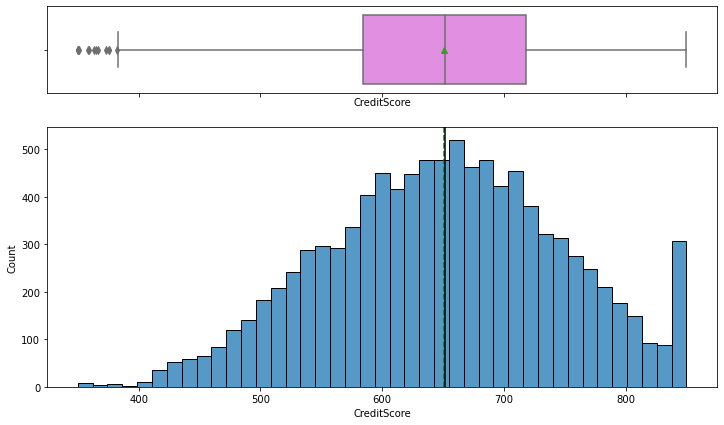

In [19]:
histogram_boxplot(df, 'CreditScore')

In [20]:
print("Column: CreditScore has skewness ",df['CreditScore'].skew())

Column: CreditScore has skewness  -0.07160660820092675


As a note: Generally skewness is not going to be large enough to worry about if it is between -1 and 1. Most, if not all, statistical tests are robust enough to handle skew within this range.

This skew is well within that range. It seems normally distributed, with a bit of a jump at the end as credit score is capped at 850.

In [21]:
#Checking quartiles for outliers
outlier_ID(df,'CreditScore',2)

The quartiles for CreditScore are the following: Q1 = 584.0, Q3 = 718.0, 2*IQR = 268.0


5494    383
9210    382
7       376
942     376
9356    373
8154    367
2579    365
1193    363
1405    359
1962    358
2473    351
1631    350
1838    350
8723    350
8762    350
9624    350
Name: CreditScore, dtype: int64

Observations:
* Very normally distributed
* Almost no skew
* Average credit score in the US is 706, so we have a fairly good sample here in terms of credit.

It looks like we have a few outliers in the low range. Forbes.com is telling me the lowest possible credit score for FICO and VantageScore is 300, so it's a little weird it bottoms out at 350, but it's not impossible. I don't see any need to adjust these values.

It's very strange that the German residents are given a score between 350 and 850. Germany uses the SCHUFA credit system which starts at 100 and drops as it gets lower.

I suppose the data engineers already did the conversions for us (thanks!), or these customers were given scores with multiple systems.

### Observations on Age

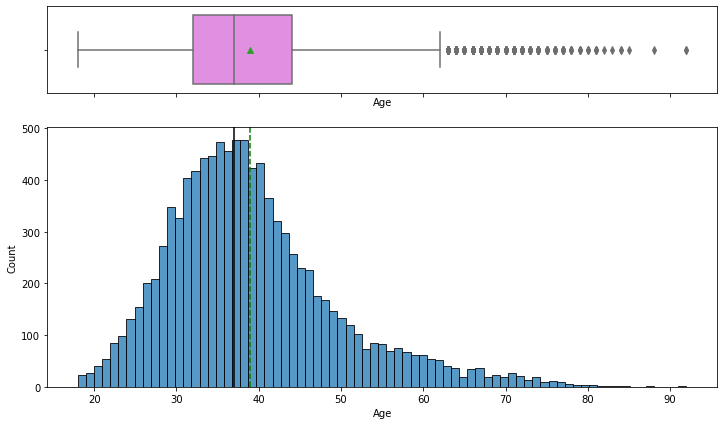

In [22]:
histogram_boxplot(df, 'Age', bins=75)

In [23]:
print("Column: Age has skewness ",df['Age'].skew())

Column: Age has skewness  1.0113202630234552


In [24]:
#Checking quartiles for outliers
outlier_ID(df,'Age',3)

The quartiles for Age are the following: Q1 = 32.0, Q3 = 44.0, 3*IQR = 36.0


6759    92
6443    92
2458    88
3033    85
3531    84
        ..
3110    74
7692    74
3366    74
3499    74
2433    74
Name: Age, Length: 72, dtype: int64

Observations:
* The skew is right on the line of acceptable.
* The outliers are all possible. 92 year olds happen.


### Observations on Tenure

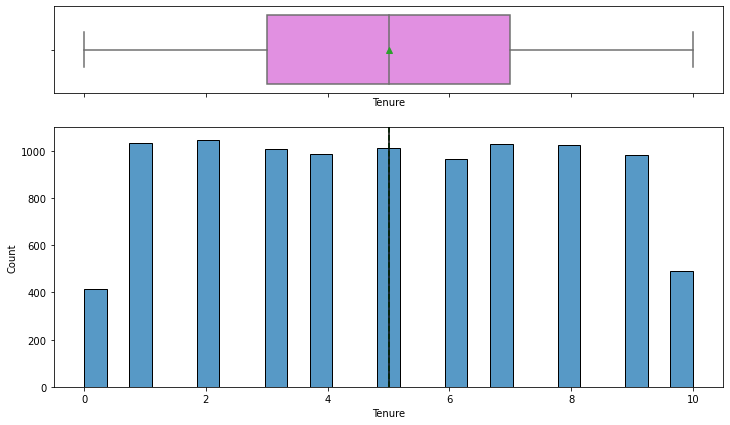

In [25]:
histogram_boxplot(df, 'Tenure')

In [26]:
print("Column: Tenure has skewness ",df['Tenure'].skew())

Column: Tenure has skewness  0.01099145797717904


In [27]:
#Checking quartiles for outliers
outlier_ID(df,'Tenure',2)

The quartiles for Tenure are the following: Q1 = 3.0, Q3 = 7.0, 2*IQR = 8.0


Series([], Name: Tenure, dtype: int64)

Observations:
* Very smooth distribution, not normal, but evenly spread.
* Practically no skew
* Zero years? Ok, well, I suppose they are rounding down for some people.
* No outliers

### Observations on Balance

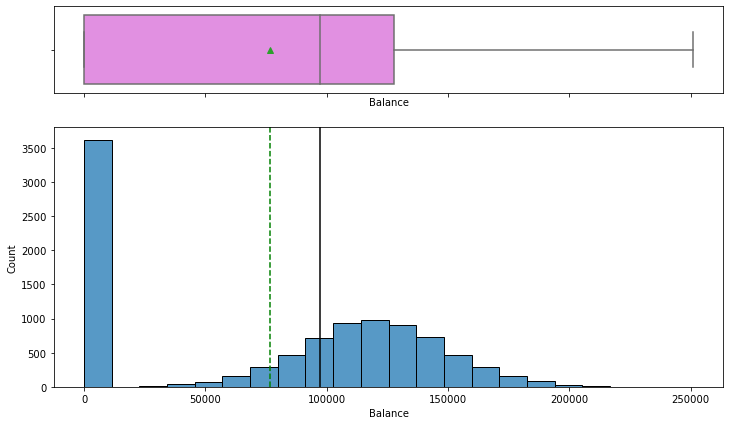

In [28]:
histogram_boxplot(df, 'Balance')

In [29]:
print("Column: Balance has skewness ",df['Balance'].skew())

Column: Balance has skewness  -0.14110871094154384


In [30]:
#Checking quartiles for outliers
outlier_ID(df,'Balance',2)

The quartiles for Balance are the following: Q1 = 0.0, Q3 = 127644.24, 2*IQR = 255288.48


Series([], Name: Balance, dtype: float64)

Observations:
* Lots of zeroes, but these are reasonable.
* Otherwise normally distributed
* Zeroes are causing some left skew, but not too extreme.
* No outliers.

### Observations on NumOfProducts

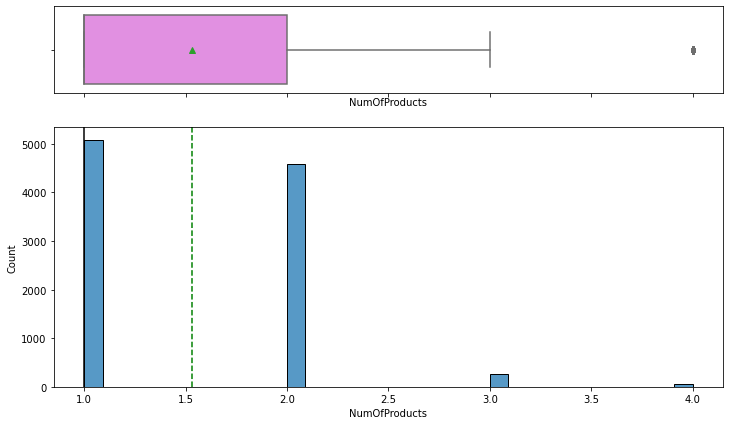

In [31]:
histogram_boxplot(df, 'NumOfProducts')

In [32]:
print("Column: NumOfProducts has skewness ",df['NumOfProducts'].skew())

Column: NumOfProducts has skewness  0.7455678882823168


In [33]:
#Checking quartiles for outliers
outlier_ID(df,'NumOfProducts',2)

The quartiles for NumOfProducts are the following: Q1 = 1.0, Q3 = 2.0, 2*IQR = 2.0


7       4
70      4
5137    4
5235    4
5386    4
5700    4
5904    4
6150    4
6172    4
6279    4
6750    4
6875    4
7257    4
7457    4
7567    4
7698    4
7724    4
7729    4
8041    4
8590    4
8683    4
8850    4
8923    4
9215    4
9255    4
9323    4
9370    4
9411    4
9540    4
5010    4
4822    4
4748    4
2614    4
1254    4
1469    4
1488    4
1701    4
1876    4
2124    4
2196    4
2285    4
2462    4
2499    4
2509    4
2541    4
2617    4
4654    4
2872    4
3152    4
3365    4
3841    4
4013    4
4014    4
4166    4
4260    4
4403    4
4511    4
4516    4
4606    4
9565    4
Name: NumOfProducts, dtype: int64

Observations:
* Some right skew. Not very extreme.
* Vast majority have one or two products.
* 4 is an outlier, but is a reasonable score and doesn't need to be treated.

### Observations on EstimatedSalary

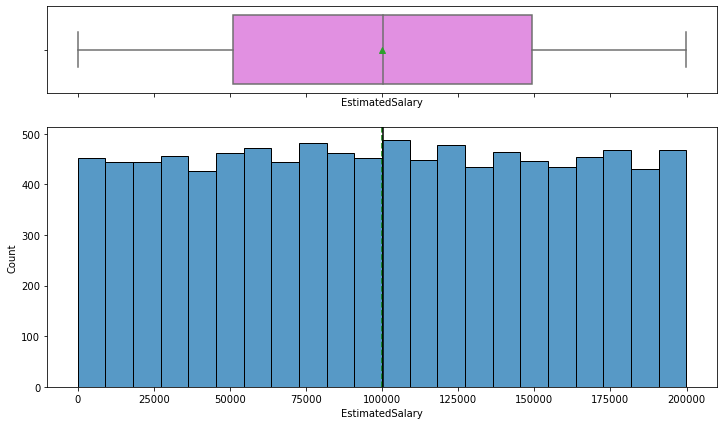

In [34]:
histogram_boxplot(df, 'EstimatedSalary')

In [35]:
print("Column: EstimatedSalary has skewness ",df['EstimatedSalary'].skew())

Column: EstimatedSalary has skewness  0.0020853576615585162


In [36]:
#Checking quartiles for outliers
outlier_ID(df,'EstimatedSalary',2)

The quartiles for EstimatedSalary are the following: Q1 = 51002.11, Q3 = 149388.2475, 2*IQR = 196772.275


Series([], Name: EstimatedSalary, dtype: float64)

Observations:
* That is a very even spread. Linear increase.
* No outliers

## Categorical Features

### Observations on Surname

We can't really do a barplot on Surname, there are too many names (2932 unique names). The most common name is only 32 (Smith).

To engineer something useful out of this, we're going to try using ethnicolr to predict the race and ethnicity of each of these surnames.

ethnicolr is a library that constructed a predictive algorithm from the US census data, Florida voting registration data, and Wikipedia data to predict race and ethnicity based on first or last name. We only have last names here, but it will still work.

The sample is European, so American racial definitions are not applicable. Given that, I'll use the Wikipedia function of the library. It will give the probabilities of a host of different ethniticies that are decoupled from "race" based on skin color, which is a somewhat uniquely American concept (it differs quite a lot from country to country).

Note: ethnicolr does not work on TensorFlow 2.7 and will uninstall it and reinstall it as TensorFlow 2.5. If you encounter errors using this library, it is likely due to version incompatibility.

In [37]:
import ethnicolr as ec
#This is ethnicolr's function that derives ethnicity from wikipedia data
# It stands for "predict race/ethnicity using the wikipedia dataset from someone's last name (ln)"
# df = ec.pred_wiki_ln(df,'Surname')

In [38]:
# The above took a very long time to run, so I'm going to save it so I don't have to re-run it
# df.to_csv("bank_ethnic.csv")
df = pd.read_csv("bank_ethnic.csv")

In [39]:
# Look at the output of ethnicolr
df.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,"GreaterEuropean,WestEuropean,Hispanic_ub","GreaterEuropean,WestEuropean,Italian_mean","GreaterEuropean,WestEuropean,Italian_std","GreaterEuropean,WestEuropean,Italian_lb","GreaterEuropean,WestEuropean,Italian_ub","GreaterEuropean,WestEuropean,Nordic_mean","GreaterEuropean,WestEuropean,Nordic_std","GreaterEuropean,WestEuropean,Nordic_lb","GreaterEuropean,WestEuropean,Nordic_ub",race
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,...,0.012650,0.046246,0.038809,0.009117,0.010606,0.018003,0.015230,0.002958,0.003300,"GreaterEuropean,British"
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,...,0.019833,0.019037,0.009604,0.003845,0.004950,0.010672,0.008206,0.002506,0.003351,"GreaterEuropean,British"
2,Onio,502,France,Female,42,8,159660.80,3,1,0,...,0.014907,0.219457,0.106027,0.039778,0.042469,0.003647,0.002205,0.000737,0.000906,"Asian,GreaterEastAsian,Japanese"
3,Boni,699,France,Female,39,1,0.00,2,0,0,...,0.005328,0.313383,0.133424,0.048162,0.076490,0.009773,0.005245,0.002591,0.002843,"GreaterEuropean,WestEuropean,Italian"
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,...,0.006906,0.008071,0.005679,0.001125,0.001276,0.003513,0.002145,0.000789,0.000850,"GreaterEuropean,British"


While interesting, we won't be using the probabilities here. The final prediction should be enough. I'll go ahead and drop those.

In [40]:
# The probability columns are 12-64, so I'll drop those.
for column in df.columns[12:65]:
    df.drop([column],axis=1,inplace=True)

The output also goes from general to specific. For example, Japanese and Indians are both Asians first. Let's expand the race column by comma and look at the values.

In [41]:
df['Ethnicity'] = df['race'].str.rsplit(',').str[-1] # Get the last entry after a comma
df['Ethnicity'].value_counts() # Unique entries for Ethnicity

British               4787
Italian               1483
EastAsian             1234
Africans               741
EastEuropean           659
Hispanic               313
Japanese               242
Jewish                 169
IndianSubContinent     135
Muslim                  87
French                  78
Nordic                  37
Germanic                35
Name: Ethnicity, dtype: int64

More than 2000 of our sample lives in Germany but most of them don't have a Germanic surname? Well, OK. Let me sanity check some of these.

In [42]:
# Let's set aside those living in Germany without Germanic names and look some up manually
df[(df['Geography'] == 'Germany') & (df['Ethnicity'] != 'Germanic')]

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,race,Ethnicity
7,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,"GreaterEuropean,WestEuropean,Italian",Italian
15,Goforth,616,Germany,Male,45,3,143129.41,2,0,1,64327.26,0,"GreaterEuropean,British",British
16,Romeo,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,"GreaterEuropean,WestEuropean,Italian",Italian
26,Young,756,Germany,Male,36,2,136815.64,1,1,1,170041.95,0,"GreaterEuropean,British",British
28,Mcwilliams,574,Germany,Female,43,3,141349.43,1,1,1,100187.43,0,"GreaterEuropean,British",British
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,Griffin,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1,"GreaterEuropean,British",British
9984,Echezonachukwu,602,Germany,Male,35,7,90602.42,2,1,1,51695.41,0,"GreaterAfrican,Africans",Africans
9986,Bartlett,673,Germany,Male,47,1,183579.54,2,0,1,34047.54,0,"GreaterEuropean,British",British
9990,Nkemakonam,714,Germany,Male,33,3,35016.60,1,1,0,53667.08,0,"GreaterAfrican,Africans",Africans


Cross-referencing Behind the Name, a website about the origin of names:
* Obinna isn't listed
* Goforth is English
* Romeo is Italian
* McWilliams is Scottish/Irish
* Griffin is Welsh or English
* Echezonachukwu isn't listed (but it's definitely not German)
* Bartlett is English
* Nkemakonam isn't listed (but is clearly not German)
* Sabbatini is Italian

For the names in Behind the Name, Ethnicolr was 100% accurate. I'm satisfied. Maybe most of our Germans are actually foreigners living in Germany and that is why they have a foreign credit score.

My only other concern is EastAsian exists separately from Japanese, which is weird. But, it's not the end of the world. There are a lot of small Asian countries that may as well be grouped together, otherwise we'd end up with a huge number of categories.

This has greatly reduced the number of categories from name while hopefully maintaining some of the meaningful information present in the feature. I'm going to go ahead and drop race and surname now.

In [43]:
# Dropping race
df.drop(['race'], inplace=True, axis=1)

In [44]:
# Dropping Surname
df.drop(['Surname'], axis=1, inplace=True)

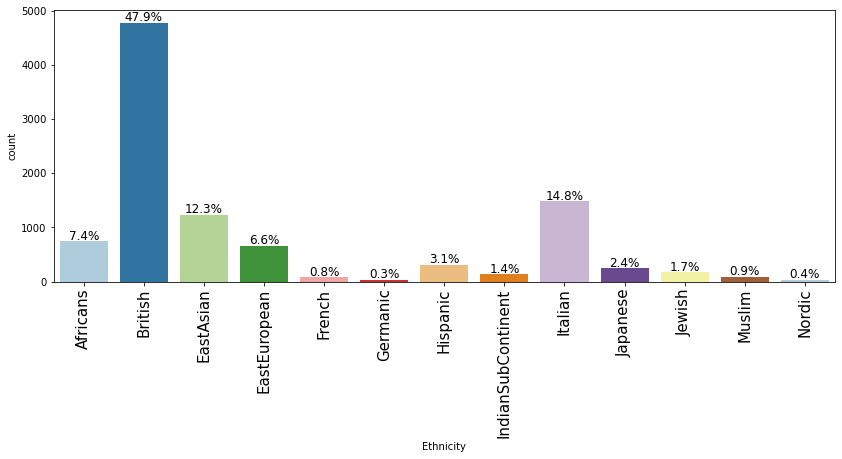

In [45]:
# Let's check out our new feature
labeled_barplot(df,'Ethnicity',perc=True)

Observations:
* Our customers live in three countries: Germany, France, and Spain. However, German, French, and Spanish surnames are extremely uncommon. It seems our sample are a bunch of foreigners living abroad or their descendents.
* The large majority of our customers are from one part of Britain or another.


A note on ethics:

It is an ethical question on whether or not people should be judged by their immutable characteristics. If the objective was to give out loans or some other matter, separating our sample by this characteristic would be inappropriate. However, I feel the nature of the problem is fundamentally marketing, and as such it is important to recognize differences among groups as they appear. It is not necessarily true that British would want the same treatment or services as an East Asian in general.

### Observations on Geography

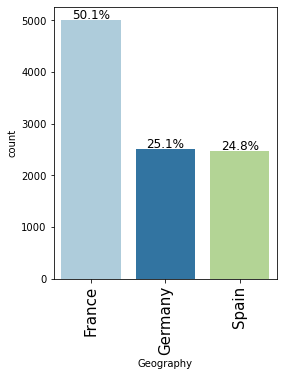

In [46]:
labeled_barplot(df,'Geography',perc=True)

Observations:
* Most of our customers are in France, but just barely.
* Germany and Spain are roughly even.

### Observations on Gender

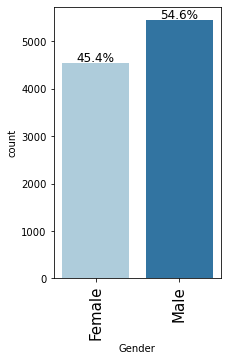

In [47]:
labeled_barplot(df,'Gender',perc=True)

Observations:
* We have slightly more men than women in our sample.

### Observations on HasCrCard

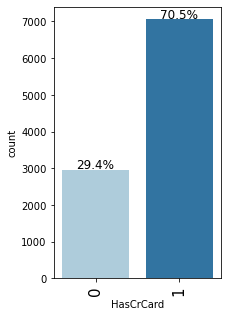

In [48]:
labeled_barplot(df,'HasCrCard',perc=True)

Observations:
* To no one's surprise, most people have a credit card.

### Observations on IsActiveMember

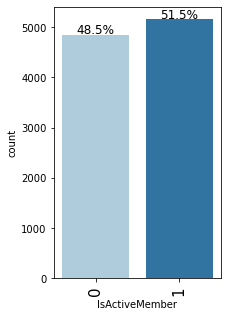

In [49]:
labeled_barplot(df,'IsActiveMember',perc=True)

Observations:
* About half of our sample doesn't use our bank all that much.
    

### Observations on the target feature Exited

In [50]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Ethnicity
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,British
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,British
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Japanese
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Italian
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,British


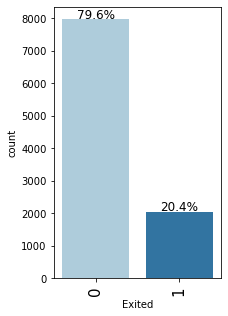

In [51]:
labeled_barplot(df,'Exited',perc=True)

Observations:
* Our target feature is imbalanced, with only 20.4% having left within six months

Now let's look at how everything interacts with our target variable.

## Multivariate Interactions

I want to see how these variables interact in the EDA so that when we run our model we don't have any surprises.

First let's look at some overal interactions and then we'll go through how each feature interacts with the target variable.

### Pairplot of Columns

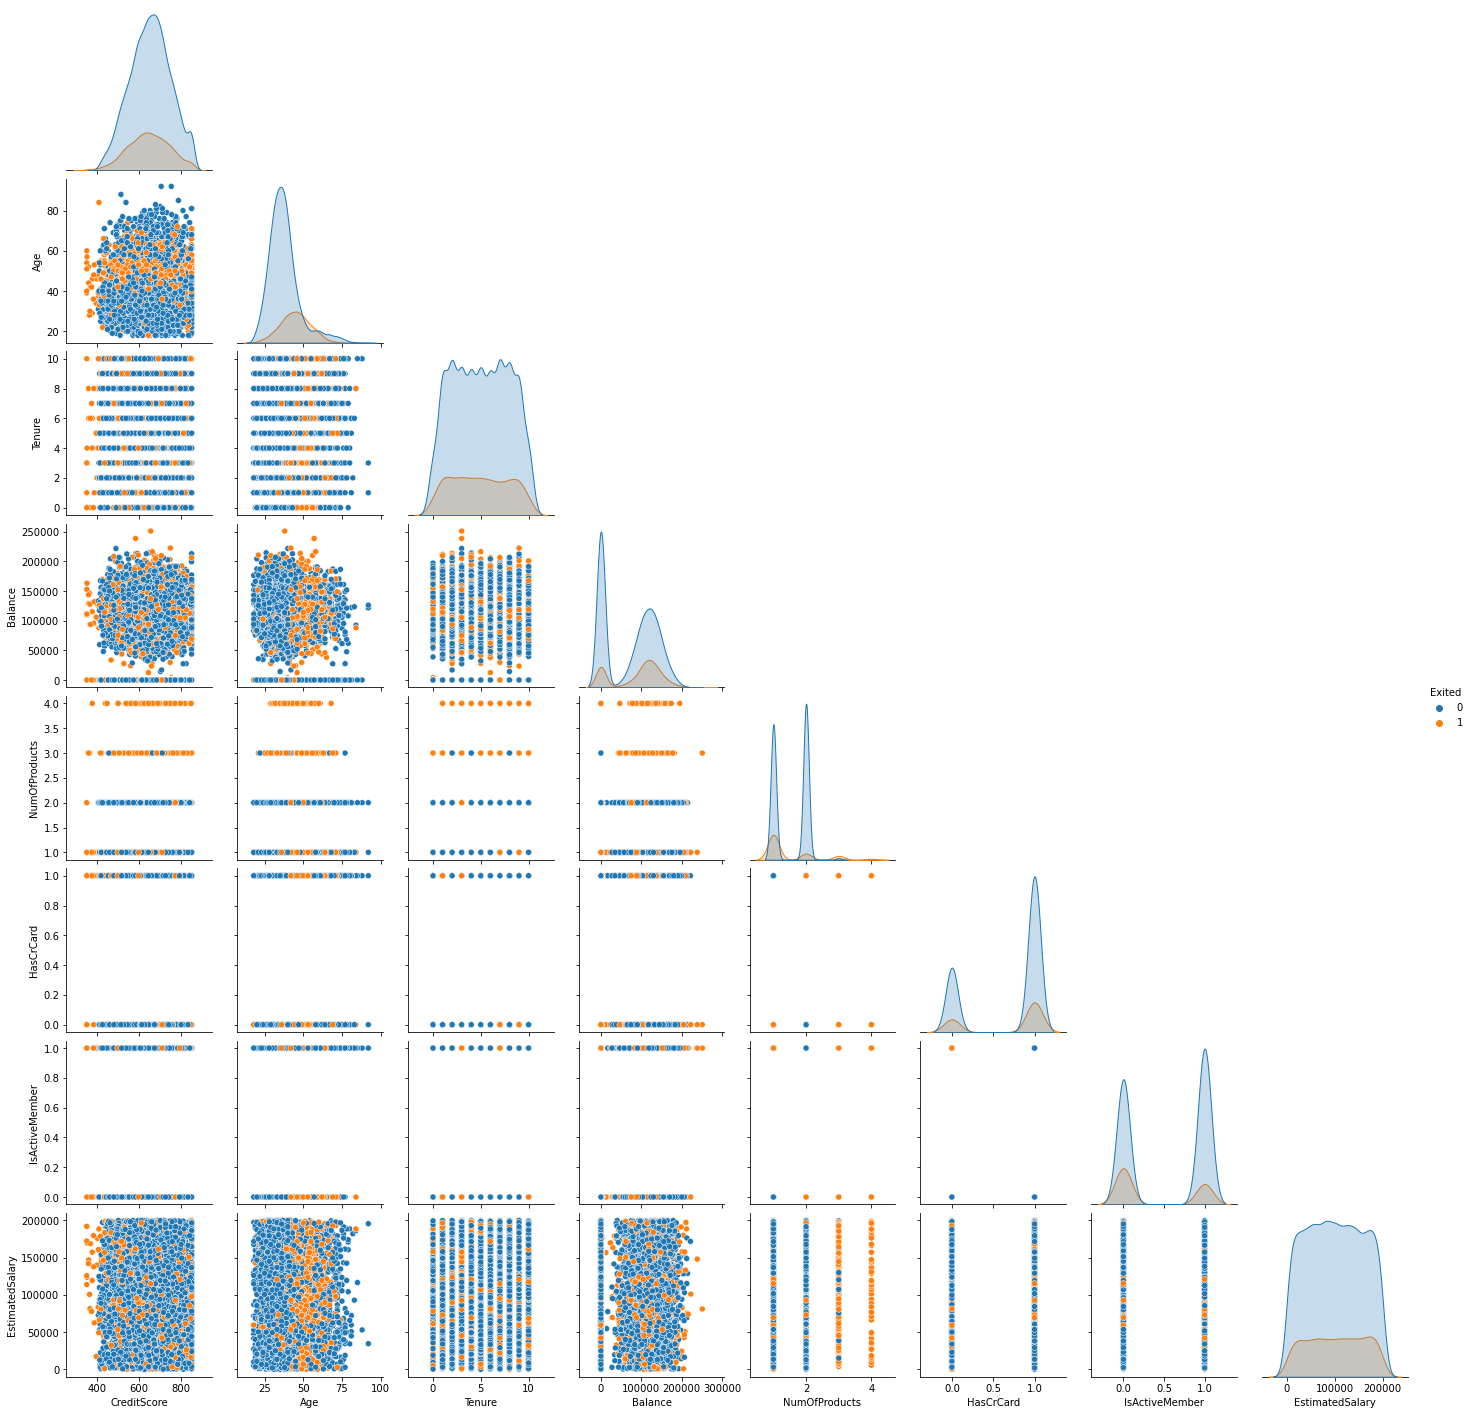

In [52]:
sns.pairplot(df, hue="Exited",corner=True)

Observations:

* Age seems to have two thresholds, where young people or very old people are less likely to exit.
* I don't see any linear relationships or sigmoid relationships with the categories.
* Seems like having a zero balance makes one less likely to exit.

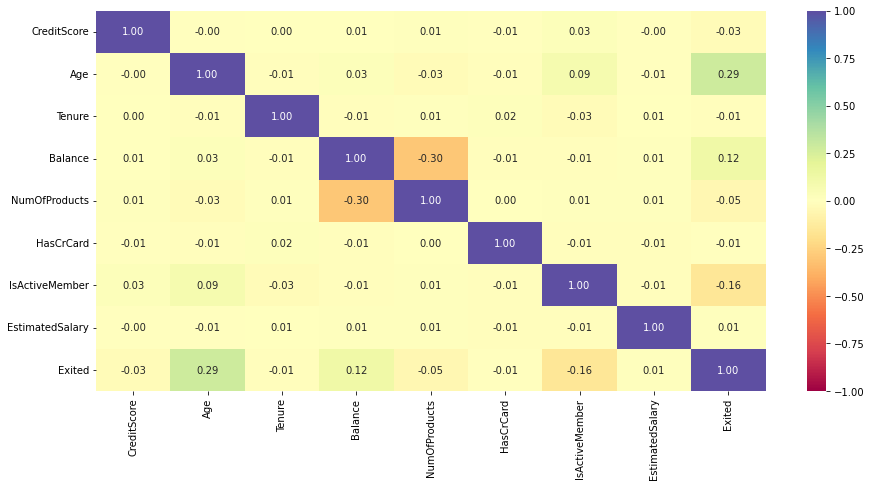

In [53]:
#Making a correlation heat plot
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Observations:
* All of the features are largely independent from one another.
* Age has a weak correlation with Exited, in line with our observation above.
* Number of Products seems weakly negatively correlated with balance.

Ok, time for a deep dive for how everything interacts with Exited.

### Interactions between Exited and CreditScore

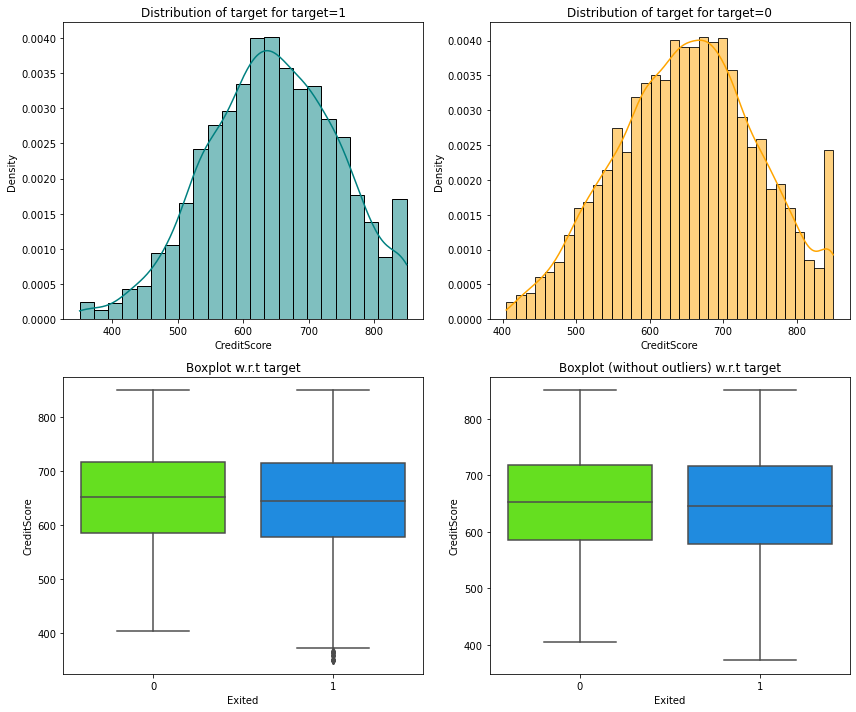

In [54]:
distribution_plot_wrt_target(df, "CreditScore", "Exited")

There doesn't seem to be any difference here. This feature will be unimportant.

### Interactions between Exited and Geography        

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


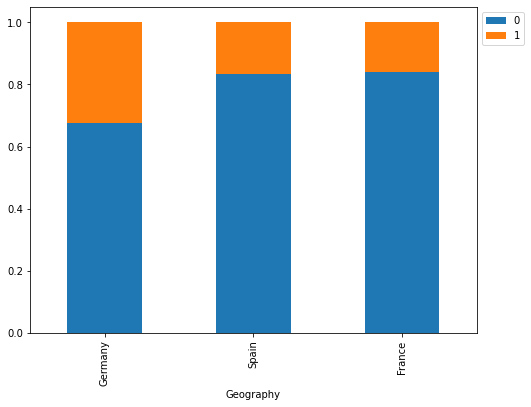

In [55]:
stacked_barplot(df, "Geography", "Exited")

Those living in Spain or France seem equally likely to exit. However, those in Germany seem more likely to.

Those in Germany seem more likely to exit.

### Interactions between Exited and Gender           

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


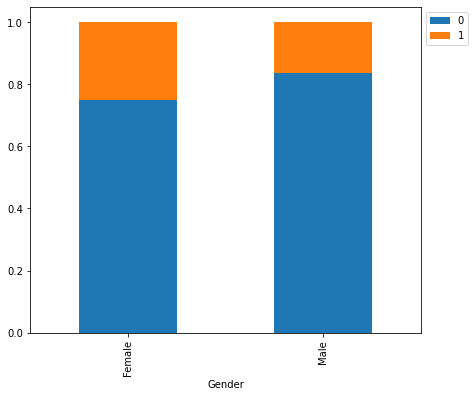

In [56]:
stacked_barplot(df, "Gender", "Exited")

Women seem slightly more likely to exit.

### Interactions between Exited and Age              

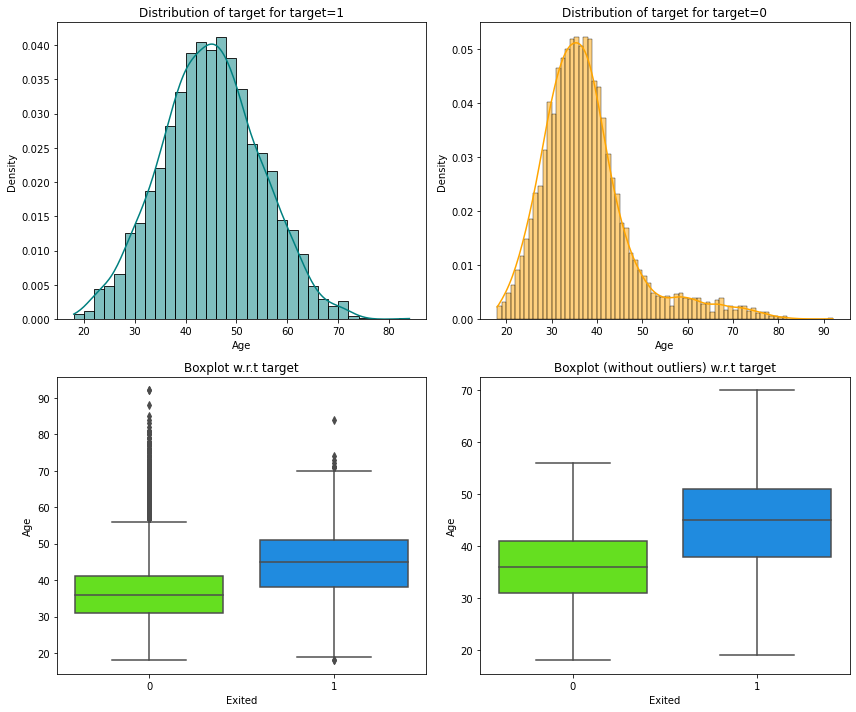

In [57]:
distribution_plot_wrt_target(df, "Age", "Exited")

Older people seem slightly more likely to exit overall, except one thing stands out to me:

The tail extending to the right almost completely vanishes for the Exited sub-group. There may be a threshold here. I'll check. First, how many people are 70 or over?

In [58]:
# Count all of those in the sample over 70
(df['Age'] >= 70).value_counts()[1]

151

In [59]:
# Now count all of those in the sample over 70 that exited
df[(df['Age'] >= 70) & (df['Exited'] == 1)].sum()[-2]

15

Thus we have a strong trend in age up until a point. As one gets older, they are more likely to exit until they hit about 70 years old. After 70, only 10% exit in six months. That's about half the base rate of 20.4%.

This is a non-linear relationship.

Ultimately because there are very few people over 70 this threshold will be unimportant, but it is still noteworthy.

### Interactions between Exited and Tenure           

Exited     0     1    All
Tenure                   
All     7963  2037  10000
1        803   232   1035
3        796   213   1009
9        771   213    984
5        803   209   1012
4        786   203    989
2        847   201   1048
8        828   197   1025
6        771   196    967
7        851   177   1028
10       389   101    490
0        318    95    413
------------------------------------------------------------------------------------------------------------------------


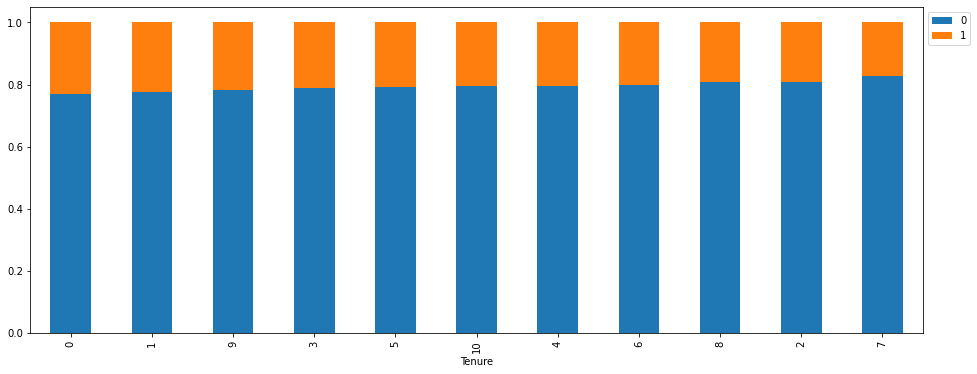

In [60]:
stacked_barplot(df, "Tenure", "Exited")

The ratio of exited to retained is almost identical across tenure, and what little change there is seems non-linear. I'd say the difference is likely due to random chance.

This feature will be unimportant.

### Interactions between Exited and Balance          

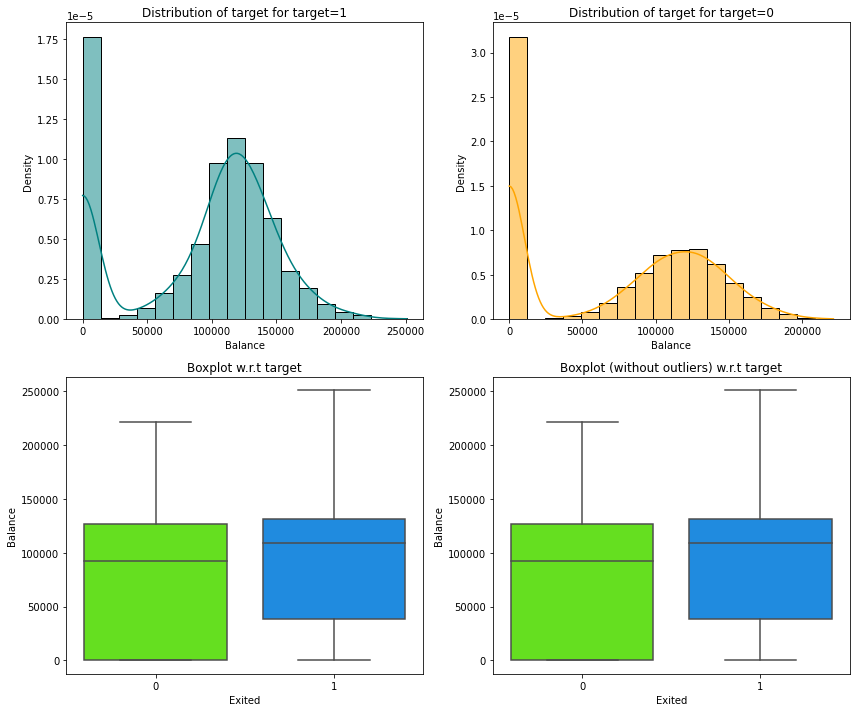

In [61]:
distribution_plot_wrt_target(df, "Balance", "Exited")

There are more people with zero balance in the "stay" group than the exited group. Otherwise the distribution seems similar.

Ultimately I don't think this will be all that important. There is a small impact here, if any.

### Interactions between Exited and NumOfProducts

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


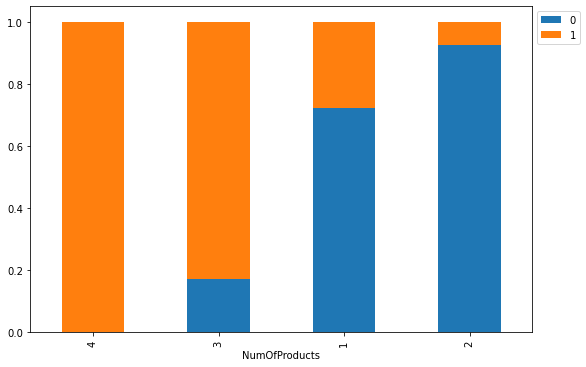

In [62]:
stacked_barplot(df, "NumOfProducts", "Exited")

Whoa now that is something I did not expect: There is a definite and clear trend where those with high amounts of products exit the bank. They must be really unsatisfied with the bank's products!

Because the number of people with 3 or 4 products is low, this factor may not be important in the end. However, it's definitely something to note. We're not in a good spot if encouraging people to buy more of our products makes them less loyal.

### Interactions between Exited and HasCrCard        

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


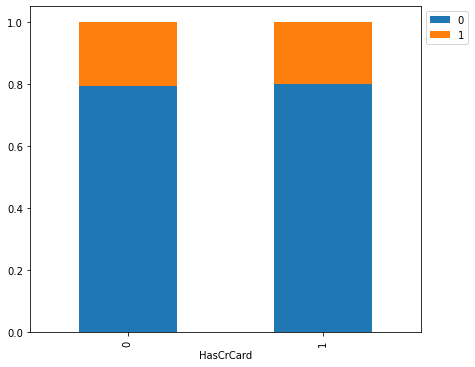

In [63]:
stacked_barplot(df, "HasCrCard", "Exited")

No difference here. Unimportant.

### Interactions between Exited and IsActiveMember   

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


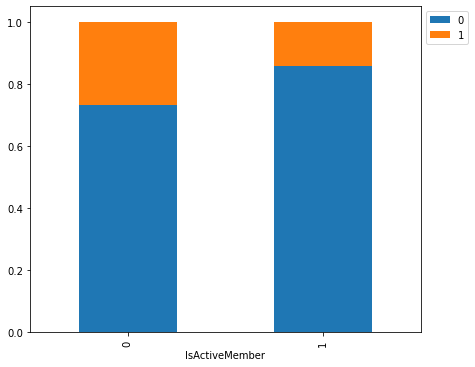

In [64]:
stacked_barplot(df, "IsActiveMember", "Exited")

Inactive members are slightly more likely to exit. This makes intuitive sense to me.

### Interactions between Exited and EstimatedSalary  

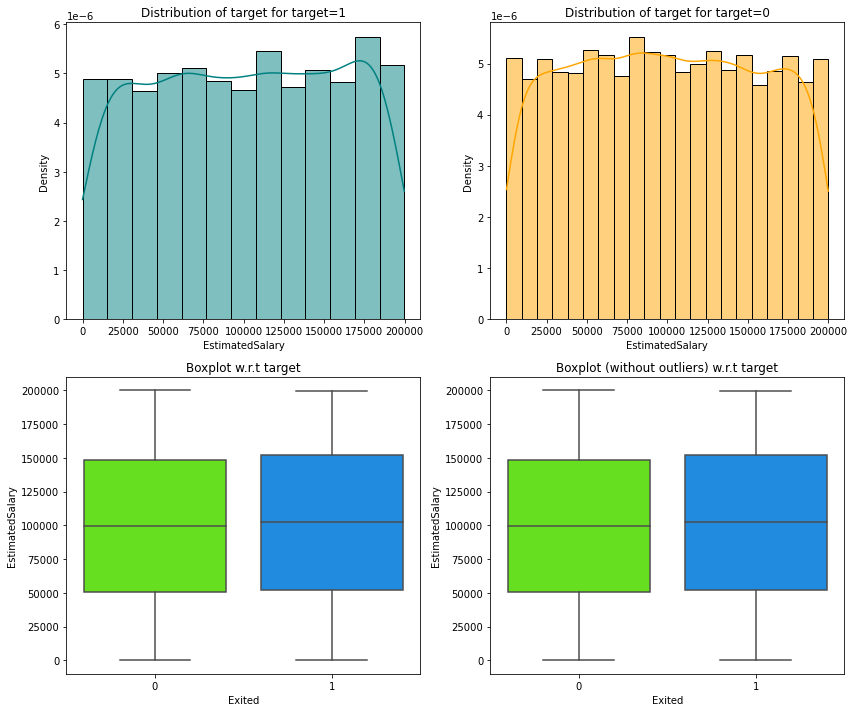

In [65]:
distribution_plot_wrt_target(df, "EstimatedSalary", "Exited")

Salary seems to make no difference on whether they will exit or not.

### Interactions between Exited and Ethnicity

Exited                 0     1    All
Ethnicity                            
All                 7963  2037  10000
British             3799   988   4787
Italian             1203   280   1483
EastAsian            985   249   1234
Africans             594   147    741
EastEuropean         518   141    659
Hispanic             246    67    313
Japanese             193    49    242
Jewish               135    34    169
IndianSubContinent   106    29    135
Muslim                63    24     87
French                61    17     78
Germanic              28     7     35
Nordic                32     5     37
------------------------------------------------------------------------------------------------------------------------


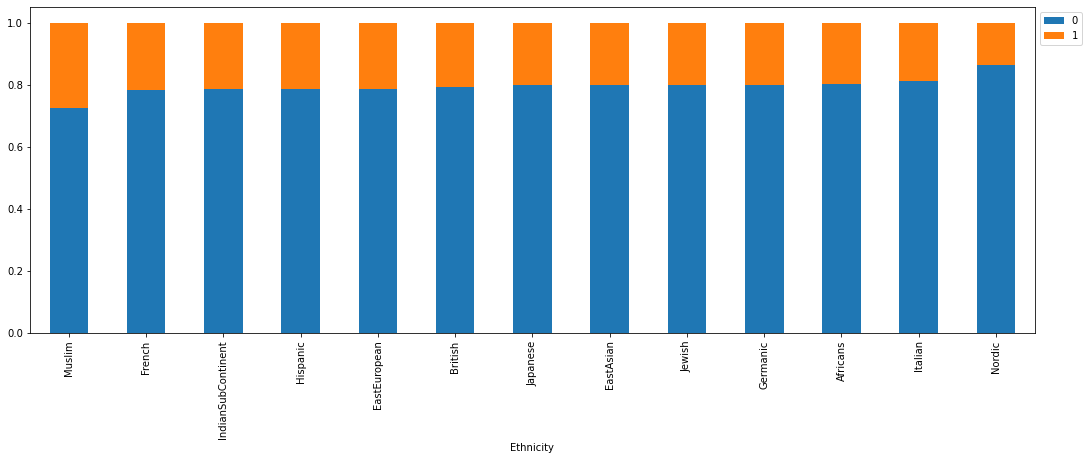

In [66]:
stacked_barplot(df, "Ethnicity", "Exited")

Some ethnicities are more likely to exit than others. We seem to have retention problems with our Muslim customers, whereas our Nordic customers are less likely to exit, though there are very few of both Muslims and Nords.

## EDA Summary and Conclusions

We're going to be making a neural network. These networks are still black boxes, so predictions on which feature are more or less important can only be made by removing/adding the features and re-running the network to see if we have improved performance. We'll be doing a lot of that later.

For now, I expect the following:

* Creditscore: unimportant
* Geography: Germans exit more
* Gender: women exit more
* Age: important but non-linear relationship
* Tenure: small if any impact
* Balance: If zero more likely to stay (make new feature?)
* Number of products: 2 is good, more than 2 is much more likely to exit 
* Credit card: unimportant
* Isactivemember: not active more likely to exit
* EstimatedSalary: unimportant
* Ethnicity: largely unimportant

Because Ethnicity had little impact and because it will make a ton of dimensions, I expect removing it entirely will be better. We'll just have to test it.

Based on the above, we can make a "most likely to exit" customer profile:

An inactive female Muslim living in Germany between ages 40-55 with four of our products and a non-zero balance would be most likely to exit within the next 6 months.

Some features we may want to engineer are:

* Balance could become a "Zero or not zero" category
* Ethnicity could become more broad, or many could be dropped

With that said, let's first make a "bare" dataset and then begin iterating to see how good we can get the model to be.

# Data Preprocessing

## Class Imbalance

In [67]:
"""
This is a classification problem, so I want to re-examine the imbalanced data.
0 will go into the 'neg' bin and 1 will go into the 'pos' bin."""
neg, pos = np.bincount(df['Exited'])
total = neg + pos
print('Customers:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Customers:
    Total: 10000
    Positive: 2037 (20.37% of total)



Although not extreme, we'll still have to keep this imbalance in mind moving forward.

## Re-structuring the Data

The data for a neural network should all be the same scale and should all be numbers. We have to convert all of the non-numerical categories into dummies so the neural net will take it. Then we have to scale everything to be between 0 and 1.

### Making Dummies

We have two options here. We can use Pandas' get_dummies or we can use tensorflow's utils.to_categorical.

The main difference is that Pandas will create multiple columns whereas TF will create a single column with a multi-dimensional tensor.

So, for a feature with five categories, get_dummies creates five columns of [0] or [1], wheras to_categorical will produce one column that looks like this: [0,0,0,0,1]

I am using get_dummies because I intend to trim several of the ethnicities, and it will be a lot easier to do this if they have their own column. It also maintains better interpretability.

In [68]:
# Pull up a list of columns just to remind us which need to be dummied
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
 11  Ethnicity        10000 non-null  object 
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [69]:
#Function to take a column, dummy it, then add it to our df
def get_dummy(column):
    #Make the dummies
    global df
#     dummies = keras.utils.to_categorical(y_train, 3)
    dummies = pd.get_dummies(df[column],drop_first=False)
    #Add them to the current df
    df = pd.concat([df,dummies],axis=1)


In [70]:
# Just grab all the objects and run them through our new user function
for column in df.columns:
    if df[column].dtype == object:
        get_dummy(column)

In [71]:
# Now drop the originals
df.drop(['Geography'],axis=1,inplace=True)
df.drop(['Gender'],axis=1,inplace=True)
df.drop(['Ethnicity'],axis=1,inplace=True)

In [72]:
# and convert all data types to float32 for easy processing
for column in df.columns:
    df[column] = tf.cast(df[column], dtype=tf.float32)

In [73]:
# Check to see if it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  float32
 1   Age                 10000 non-null  float32
 2   Tenure              10000 non-null  float32
 3   Balance             10000 non-null  float32
 4   NumOfProducts       10000 non-null  float32
 5   HasCrCard           10000 non-null  float32
 6   IsActiveMember      10000 non-null  float32
 7   EstimatedSalary     10000 non-null  float32
 8   Exited              10000 non-null  float32
 9   France              10000 non-null  float32
 10  Germany             10000 non-null  float32
 11  Spain               10000 non-null  float32
 12  Female              10000 non-null  float32
 13  Male                10000 non-null  float32
 14  Africans            10000 non-null  float32
 15  British             10000 non-null  float32
 16  EastA

Everything is float32, original categories are gone, we're good to go.

### Splitting the Data

In [74]:
# Specify the data 
X = df.drop(columns="Exited")

y = df["Exited"]

In [75]:
y.value_counts()

0.0    7963
1.0    2037
Name: Exited, dtype: int64

In [76]:
# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# y_train = tf.keras.utils.to_categorical(y_train, 2)
# y_test = tf.keras.utils.to_categorical(y_test, 2)

### Scaling the Data

We want to scale all of the data so that our predictions are not dominated by high value features like salary. We only fit the scaler to X_train so that it doesn't peek at the test data.

In [77]:
# Define the scaler
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [78]:
print(f'X_train shape{X_train.shape}')
print(f'X_test shape{X_test.shape}')
print(f'y_train shape{y_train.shape}')
print(f'y_test shape{y_test.shape}')

X_train shape(8000, 26)
X_test shape(2000, 26)
y_train shape(8000,)
y_test shape(2000,)


### Class Weights
Throughout this process we need to have a dictionary weighing the different classes. By putting weights into our algorithms we can bypass a lot of the negatives of having an imbalanced dataset, and encourage the neural network to not learn the negative class too closely.

Below every time we're getting ready to split/re-split the data I'll re-set the class weights to ensure it is kept up to date in every iteration.

In [79]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6271558482282847, 1: 2.466091245376079}

In [80]:
class_weight_list = [0.6271558482282847, 2.466091245376079]

# Model Building

## Approach:

1. Train a base model on the base training data
2. Create a hypertuning model
3. Try different hypertuning methods
4. Create models for different feature combinations
5. Compare performances

## Model Evaluation Criteria

### The Model can make wrong predictions as:
1. Predicting a customer will exit when they won't
2. Predicting a customer won't exit when they will

### Which case is more important?
1. If a customer won't exit and we think that they will, we lose the effort of trying to retain them.
2. If a customer will exit and we don't catch it, we lose a valuable customer.

### Which metric to optimize?

It seems to me that we should try our best to minimize false negatives. Many of our strategies to retain customers will probably be encouraging them to use our products more, and that's a good thing even if we don't risk losing that customer. However, we don't want to just advertise to everyone.

Unfortunately, the best way to maximize recall and predict every positive case is to just assume every single case is positive. Doing this means we catch 100% of true positives, but the accuracy will be shockingly low.

We want to find a balance between this scenario and accuracy. We should be willing to sacrifice some accuracy but not all.

Therefore an efficient bang-for-buck approach is good. We'll be prioritizing AUC-ROC as our metric (usually referred to as just AUC). This should give us a fairly high recall without putting our accuracy in the gutter.


In [81]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'), # Total true positives
      tf.keras.metrics.FalsePositives(name='fp'),# Total false positives
      tf.keras.metrics.TrueNegatives(name='tn'), # Total true negatives
      tf.keras.metrics.FalseNegatives(name='fn'), # Total false negatives
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'), # ROC-AUC score
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Evaluation and Model Building Functions

In [82]:
def evaluate_model(model, X_test, y_test):
    """
    evaluate model on test set and show results in dataframe.
    
    Parameters
    ----------
    model : keras model
        trained keras model.
    X_test : numpy array
        Features of holdout set.
    y_test : numpy array
        Labels of holdout set.
        
    Returns
    -------
    display_df : DataFrame
        Pandas dataframe containing evaluation results.
    """
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df


In [83]:
def AUC_ROC_Plot(model, name='Model Performance'):
    #Plotting the AUC-ROC curse to see which threshold gives us the greatest gains
    logit_roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 0])
    fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:, 0])
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label= f"{name} (area = %0.2f)" % logit_roc_auc_train)
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [84]:
def optimal_threshold(model):# Optimal threshold as per AUC-ROC curve
    # The optimal cut off would be where tpr is high and fpr is low
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 0])

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_auc_roc = thresholds[optimal_idx]
    return optimal_threshold_auc_roc
#     print(f'The model\'s optimal threshold is {optimal_threshold_auc_roc}')

In [85]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 0]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [86]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 0]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score
    auc = roc_auc_score(target, pred) #To compute ROC-AUC

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "AUC": auc,
        },
        index=[0],
    )

    return df_perf

In [87]:
def build_model(hp):
    """
    Builds model and sets up hyperparameter space to search.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    global class_weights
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten()) # This won't actually do anything, my data is already flat.
     #I am keeping it in because it could be useful in the future.

    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.L1((hp.Float("L1 Regularizer",min_value=0.0, max_value=0.05, step=.01)))
            )) #We're choosing L1 regularization because I expect many features to be unimportant. 
                #It's best to just drop unimportant features, and L1 will do that.
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=1, activation="sigmoid"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
    
    return model

# Baseline Model

Before experimenting with the numerous hyperparameters, I'm going to just make a baseline model that has absolutely nothing fancy going on, just to see how it does.

In [88]:
#initialize the model
base_model = Sequential()

# Add the first hidden layer/input layer
base_model.add(Dense(units=16, input_dim = 26,activation='relu')) #input_dim = 26 for 26 columns

# Add the final layer. We're classifying, so we want sigmoid.
base_model.add(Dense(1,activation='sigmoid'))  # Only 1 is needed: We're doing binary classification

In [89]:
#Compiling the model so we see how it looks.
base_model.compile(loss= tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=METRICS)
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                432       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


The .summary() tells us what our neural network looks like. The second element in the shape is how many nodes there are. As you can see, the first hidden layer has 16 and the output has 1, just as we designated above.

In [90]:
"""
We want to record the history of training the model. The history shows how our various metrics
changed overtime. We can then plot these values to see if our model is converging or not."""
base_model_history = base_model.fit(X_train,
                                    y_train,
                                    epochs=50, batch_size=500,verbose=0,
                                    validation_split=0.2,
                                    class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


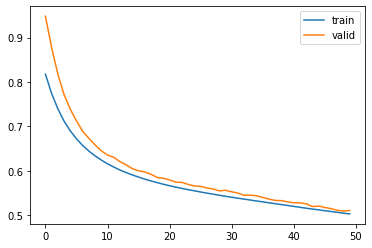

In [91]:
# Capturing learning history per epoch
hist  = pd.DataFrame(base_model_history.history)
hist['epoch'] = base_model_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


That's a pretty good graph. Starts out high but as the NN learns the data it drops. I notice later it gets a little unstable so I think 20 epochs will suffice.

In [92]:
# Fitting the model is actually making it. I kept it verbose so we can see the numbers and not rely solely on the graph.
base_model.fit(X_train, y_train, epochs=20, batch_size=500,verbose=1, validation_split=0.2, class_weight=class_weights) 

Epoch 1/20
13/13 [==============================] - 0s 3ms/step - loss: 0.5012 - tp: 986.0000 - fp: 1222.0000 - tn: 3880.0000 - fn: 312.0000 - accuracy: 0.7603 - precision: 0.4466 - recall: 0.7596 - auc: 0.8385 - prc: 0.6086 - val_loss: 0.5090 - val_tp: 233.0000 - val_fp: 300.0000 - val_tn: 976.0000 - val_fn: 91.0000 - val_accuracy: 0.7556 - val_precision: 0.4371 - val_recall: 0.7191 - val_auc: 0.8317 - val_prc: 0.6051
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.4998 - tp: 978.0000 - fp: 1199.0000 - tn: 3903.0000 - fn: 320.0000 - accuracy: 0.7627 - precision: 0.4492 - recall: 0.7535 - auc: 0.8393 - prc: 0.6115 - val_loss: 0.5040 - val_tp: 233.0000 - val_fp: 296.0000 - val_tn: 980.0000 - val_fn: 91.0000 - val_accuracy: 0.7581 - val_precision: 0.4405 - val_recall: 0.7191 - val_auc: 0.8329 - val_prc: 0.6091
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.4980 - tp: 982.0000 - fp: 1205.0000 - tn: 3897.0000 - fn: 316.0000 - accuracy: 0

That's a pretty good performance, but there is one more step. We have to find the ideal threshold.

The sigmoid function produces a probability, not just a straight number. The probability then passes through a threshold: if the probability rises above a certain number then it transforms into a 1, otherwise it's a 0.

Setting that threshold at the optimal point between true positives and false positives helps us balance out the "just say everything is positive" problem. We get the best bang for our buck this way.

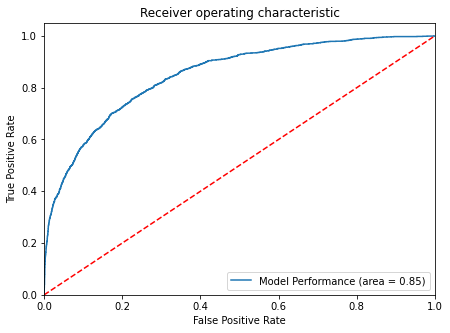

In [93]:
"""
We want to plot out the AUC_ROC curve to pick a threshold that maximizes model performance
"""

AUC_ROC_Plot(base_model)

In [94]:
# This is the threshold we will use when computing performance. It's usually around 0.5 because of our class weights.
optimal_threshold(base_model)

0.5019918

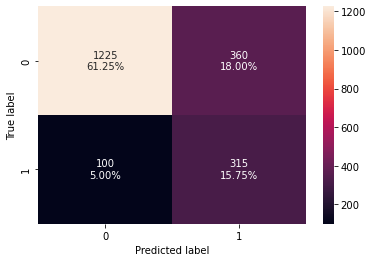

In [95]:
# All of our confusion matricies will be of the test set. Doing well on test is the goal.
confusion_matrix_sklearn_with_threshold(base_model, X_test, y_test,
                                        threshold=optimal_threshold(base_model))

In [96]:
# We're saving all of the performance in a table so that we can compare them later.
base_model_train_perf = model_performance_classification_sklearn_with_threshold(
    base_model, X_train, y_train, threshold = optimal_threshold(base_model))
print("Training performance:")
base_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.77,0.757707,0.459268,0.571894,0.765416


In [97]:
base_model_test_perf = model_performance_classification_sklearn_with_threshold(
    base_model, X_test, y_test, threshold = optimal_threshold(base_model))
print("Test performance:")
base_model_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.77,0.759036,0.466667,0.577982,0.765953


That's decent performance for an untuned model. Recall and AUC are high, which is what we wanted as we want to prioritize identifying which customers are going to exit. However, it didn't come at the total expensive of precision and accuracy. 0.77 isn't terrible.

Sklearn is using the threshold we found with the AUC plots. However, there is another way to measure a model's performance that uses its own internal method to set the threshold: model.evaluate from TensorFlow.

My evaluate_model function was written using this function.

We're going to evaluate all models using both evaluation methods. It may help us parse out which one is best for the job.

In [98]:
# Evaluate model on test set and add results to dataframe
results = evaluate_model(base_model, X_test, y_test)

# Set index to 'Baseline'
results.index = ['Baseline']

# Display results
results.head()

63/63 [==============================] - 0s 581us/step - loss: 0.4863 - tp: 316.0000 - fp: 362.0000 - tn: 1223.0000 - fn: 99.0000 - accuracy: 0.7695 - precision: 0.4661 - recall: 0.7614 - auc: 0.8417 - prc: 0.6459


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851


As we can see the results are similar but not identical. For whatever reason, model.evaluate opted to move the threshold such that precision was a bit lower and recall (and auc) is a bit higher. We'll just have to keep in mind the scores will be different moving forward.

## Hypertuning the model

The thing about neural networks is that they have a massive number of hyperparameters that influence model performance. 

Obviously, adding more nodes and more layers could be helpful because it helps us project onto higher dimensional space. However, adding these comes at the risk of overfitting and tanking on the test data.

To balance out the extra nodes and layers, we can add dropouts, which turns a certain number of the nodes off and prevents large weights from appearing. We also add L1 regularization to help trim off features that are not really helping any.

There is no guarantee that those help, though. That is why we iterate though a huge number of possibilities and then pick the model that performs the best.

Our output layer will have a sigmoid activation because this is a binary classification task. We're also going to use binary cross entropy as our loss metric for the exact same reason.

When we hypertune, we first create a hypertuning space (see the build_model function, above) and then iterate through it to choose the best hyperparameters. Then we actually fit the data to those hyperparameters to make that model.

I'll add additional commentary when I do something I haven't done before. Otherwise, this should all be similar to what happened above.

In [99]:
# Build a basic model with Sequential API
b_model = keras.Sequential()
b_model.add(keras.layers.Dense(units=50, input_dim = 26, activation='relu', name='dense_1'))
b_model.add(keras.layers.Dropout(0.2)) #This time we're adding a dropout for our hidden layer
b_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Print model summary
b_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1350      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Compile puts everything together so it's ready to be run.
b_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [101]:
# Number of epochs
NUM_EPOCHS = 20

# Early stopping set after 5 epochs. This happens if loss fails to improve for 5 epochs.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train model
b_model.fit(X_train, y_train, epochs=NUM_EPOCHS,
            validation_split=0.2, callbacks=[stop_early],
            class_weight=class_weights, verbose=2)

Epoch 1/20
200/200 - 2s - loss: 0.6622 - tp: 1195.0000 - fp: 2735.0000 - tn: 3952.0000 - fn: 518.0000 - accuracy: 0.6127 - precision: 0.3041 - recall: 0.6976 - auc: 0.7108 - prc: 0.4152 - val_loss: 0.5998 - val_tp: 237.0000 - val_fp: 421.0000 - val_tn: 855.0000 - val_fn: 87.0000 - val_accuracy: 0.6825 - val_precision: 0.3602 - val_recall: 0.7315 - val_auc: 0.7578 - val_prc: 0.4748
Epoch 2/20
200/200 - 0s - loss: 0.5894 - tp: 911.0000 - fp: 1600.0000 - tn: 3502.0000 - fn: 387.0000 - accuracy: 0.6895 - precision: 0.3628 - recall: 0.7018 - auc: 0.7545 - prc: 0.4408 - val_loss: 0.5717 - val_tp: 236.0000 - val_fp: 387.0000 - val_tn: 889.0000 - val_fn: 88.0000 - val_accuracy: 0.7031 - val_precision: 0.3788 - val_recall: 0.7284 - val_auc: 0.7840 - val_prc: 0.4982
Epoch 3/20
200/200 - 0s - loss: 0.5701 - tp: 916.0000 - fp: 1514.0000 - tn: 3588.0000 - fn: 382.0000 - accuracy: 0.7038 - precision: 0.3770 - recall: 0.7057 - auc: 0.7768 - prc: 0.4758 - val_loss: 0.5568 - val_tp: 235.0000 - val_fp: 

In [102]:
# Evaluate model on test set and add results to dataframe
basic = evaluate_model(b_model, X_test, y_test)

# Set index to the name of the model
basic.index = ['basic_model']

# Display results
results = results.append(basic)
results

63/63 [==============================] - 1s 726us/step - loss: 0.4429 - tp: 302.0000 - fp: 297.0000 - tn: 1288.0000 - fn: 113.0000 - accuracy: 0.7950 - precision: 0.5042 - recall: 0.7277 - auc: 0.8536 - prc: 0.6854


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444


Compared to baseline there is very little difference. The major difference was I added a dropout this time, and we're already seeing some improvement. The auc score went a decent amount. I think the tuning will help more.

Time to tune how many layers we should have along with how many nodes, and how much (if any) l1 regularization is needed.

Also, dropout has different amounts to it. We need to see how many nodes should be dropped during the training of every layer.

All of that is baked in to the build_model function (see above) which we feed into the tuner space.

Hyperband is a type of tuner that uses random search with some early stopping to decrease computation time without losing much performance. We're going to try that first before trying Bayesian, another tuning method.

In [103]:
tuner = kt.Hyperband(build_model, # This is our user function. It tells the tuner what space to search in.
                     objective=kt.Objective("val_auc", direction="max"), #We want to maximize validation_AUC
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory="kt_dir", #This and the one below saves our tuned model so we don't have to re-run it constantly
                     project_name="kt_hyperband_weighted_regular")

INFO:tensorflow:Reloading Oracle from existing project kt_dir\kt_hyperband_weighted_regular\oracle.json
INFO:tensorflow:Reloading Tuner from kt_dir\kt_hyperband_weighted_regular\tuner0.json


In [104]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
L1 Regularizer (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.05, 'step': 0.01, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_3 (Flo

We're showing the search space here. As we saw in our build_model user function, it's searching through number of layers, regularization amount, number of nodes, amount of dropout, and the learning rate.

Now all that's remaining is for us to do the search.

In [105]:
# We still want to stop early if it isn't improving.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# .search is similar to .fit except it fits to the search space. So we're fitting X_train and y_train to the search space.
tuner.search(X_train,
             y_train,
             epochs=NUM_EPOCHS,
             validation_split=0.2, # .search helpfully creates a validation set for us so we don't have to. It's 20% of train
             callbacks=[stop_early],
             verbose=2, #It compares what it is currently testing to the running-best, displaying both.
            class_weight=class_weights)

INFO:tensorflow:Oracle triggered exit


In [106]:
# Get the optimal hyperparameters from the results
# best_hps=tuner.get_best_hyperparameters()[0]
best_hps = tuner.get_best_models()[0]
best_hps.build(X_train.shape)
best_hps.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (8000, 26)                0         
_________________________________________________________________
dense (Dense)                (8000, 448)               12096     
_________________________________________________________________
dropout (Dropout)            (8000, 448)               0         
_________________________________________________________________
dense_1 (Dense)              (8000, 192)               86208     
_________________________________________________________________
dropout_1 (Dropout)          (8000, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (8000, 32)                6176      
_________________________________________________________________
dropout_2 (Dropout)          (8000, 32)                0

The best parameters seems to be four hidden layers with varying amounts of nodes.

In [107]:
# Save the history so we can plot it
best_hps_history = best_hps.fit(X_train,
                                    y_train,
                                    epochs=20, batch_size=500,verbose=0,
                                    validation_split=0.2,
                                class_weight=class_weights)

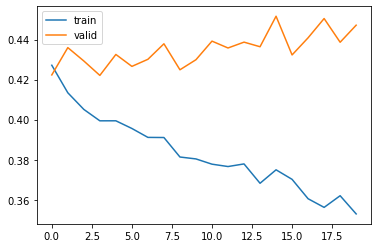

In [108]:
# Capturing learning history per epoch
hist  = pd.DataFrame(best_hps_history.history)
hist['epoch'] = best_hps_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


That is a very weird divergence. It almost immediately begins overfitting. We won't want a lot of epochs then.

In [109]:
# Now we fit it for actual predictions.
best_hps.fit(X_train,y_train,epochs = 3, batch_size = 500, class_weight=class_weights)

Epoch 1/3
16/16 [==============================] - 1s 5ms/step - loss: 0.3967 - tp: 1329.0000 - fp: 1114.0000 - tn: 5264.0000 - fn: 293.0000 - accuracy: 0.8241 - precision: 0.5440 - recall: 0.8194 - auc: 0.9019 - prc: 0.7592
Epoch 2/3
16/16 [==============================] - 0s 5ms/step - loss: 0.3899 - tp: 1335.0000 - fp: 1122.0000 - tn: 5256.0000 - fn: 287.0000 - accuracy: 0.8239 - precision: 0.5433 - recall: 0.8231 - auc: 0.9057 - prc: 0.7573
Epoch 3/3
16/16 [==============================] - 0s 5ms/step - loss: 0.3823 - tp: 1344.0000 - fp: 1035.0000 - tn: 5343.0000 - fn: 278.0000 - accuracy: 0.8359 - precision: 0.5649 - recall: 0.8286 - auc: 0.9089 - prc: 0.7689


It's telling us we have a .91 auc. That's solid. The validation/test set won't be as good, but it's a good start.

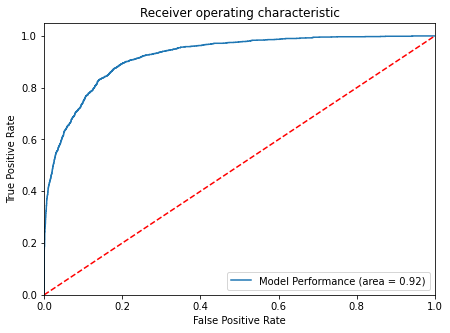

In [110]:
# Make the plot so we can get a threshold
AUC_ROC_Plot(best_hps)

In [111]:
optimal_threshold(best_hps)

0.58617896

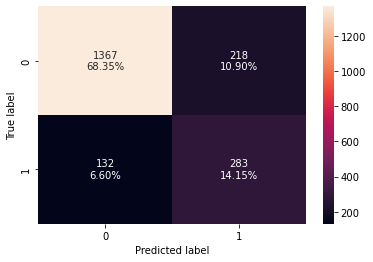

In [112]:
# Again just plugging in the threshold to a confusion matrix
confusion_matrix_sklearn_with_threshold(best_hps, X_test, y_test,threshold=optimal_threshold(best_hps))

In [113]:
best_hps_train_perf = model_performance_classification_sklearn_with_threshold(
    best_hps, X_train, y_train, threshold = optimal_threshold(best_hps))
print("Training performance:")
best_hps_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.860875,0.786067,0.624694,0.696151,0.832983


In [114]:
best_hps_test_perf = model_performance_classification_sklearn_with_threshold(
    best_hps, X_test, y_test, threshold = optimal_threshold(best_hps))
print("Test performance:")
best_hps_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.825,0.681928,0.56487,0.617904,0.772194


With our optimal threshold sklearn is telling us we have a .77 AUC. That's good, but it's overfitting a little bit.

In [115]:
# Evaluate model on test set and add results to dataframe
hyperband = evaluate_model(best_hps, X_test, y_test)

# Set index to 'Baseline'
hyperband.index = ['kt_hyperband']

# Display results
results = results.append(hyperband)
results

63/63 [==============================] - 0s 678us/step - loss: 0.4370 - tp: 296.0000 - fp: 283.0000 - tn: 1302.0000 - fn: 119.0000 - accuracy: 0.7990 - precision: 0.5112 - recall: 0.7133 - auc: 0.8422 - prc: 0.6697


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698


## Bayesian Hypersearch

Besides Hyperband, Bayesian is another form of hypersearch that remembers previous results and uses those to make an educated guess on what direction it should go for each parameter. It supposedly is quite good at what it does, so I wanted to try it and compare it to Hyperband.

Otherwise it'll go the same as before.

In [116]:
# Initialize the tuner
tuner2 = kt.BayesianOptimization(build_model,
                                 objective=kt.Objective("val_auc", direction="max"),
                                 max_trials=30,
                                 project_name='kt_Bayesian_weighted_regular')

INFO:tensorflow:Reloading Oracle from existing project .\kt_Bayesian_weighted_regular\oracle.json
INFO:tensorflow:Reloading Tuner from .\kt_Bayesian_weighted_regular\tuner0.json


In [117]:
# Display search space summary
tuner2.search_space_summary()

Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
L1 Regularizer (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.05, 'step': 0.01, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_3 (Flo

In [118]:
# Conduct the search
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner2.search(X_train,
              y_train,
              epochs=NUM_EPOCHS,
              validation_split=0.2,
              callbacks=[stop_early],
              verbose=2,
              class_weight=class_weights)

INFO:tensorflow:Oracle triggered exit


In [119]:
# Get the optimal hyperparameters from the results
best_hps2 = tuner2.get_best_models()[0]
best_hps2.build(X_train.shape)
best_hps2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (8000, 26)                0         
_________________________________________________________________
dense (Dense)                (8000, 32)                864       
_________________________________________________________________
dropout (Dropout)            (8000, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (8000, 1)                 33        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


This is a much smaller model, with many fewer layers and nodes. I expect it won't overfit as much.

In [120]:
# Record the history
best_hps2_history = best_hps2.fit(X_train,
                                    y_train,
                                    epochs=20, batch_size=500,verbose=0,
                                    validation_split=0.2,
                                 class_weight=class_weights)

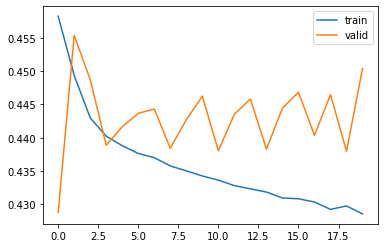

In [121]:
# Capturing learning history per epoch
hist  = pd.DataFrame(best_hps2_history.history)
hist['epoch'] = best_hps2_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


This looks very wonky but look at the scale. This is all happening in the three-decimal-point space. It's not as unstable as it appears. Even so, we want to avoid overfitting, so only 3 epochs are needed.

In [122]:
# Fit the model
best_hps2.fit(X_train,y_train,epochs = 3, batch_size = 500,class_weight=class_weights)

Epoch 1/3
16/16 [==============================] - 1s 1ms/step - loss: 0.4383 - tp: 1275.0000 - fp: 1272.0000 - tn: 5106.0000 - fn: 347.0000 - accuracy: 0.7976 - precision: 0.5006 - recall: 0.7861 - auc: 0.8767 - prc: 0.7112
Epoch 2/3
16/16 [==============================] - 0s 1ms/step - loss: 0.4368 - tp: 1268.0000 - fp: 1251.0000 - tn: 5127.0000 - fn: 354.0000 - accuracy: 0.7994 - precision: 0.5034 - recall: 0.7818 - auc: 0.8777 - prc: 0.7117
Epoch 3/3
16/16 [==============================] - 0s 1ms/step - loss: 0.4357 - tp: 1279.0000 - fp: 1282.0000 - tn: 5096.0000 - fn: 343.0000 - accuracy: 0.7969 - precision: 0.4994 - recall: 0.7885 - auc: 0.8784 - prc: 0.7126


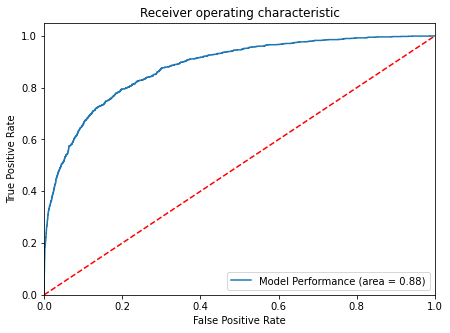

In [123]:
# Plot the curve
AUC_ROC_Plot(best_hps2)

In [124]:
# Get the threshold
optimal_threshold(best_hps2)

0.42518434

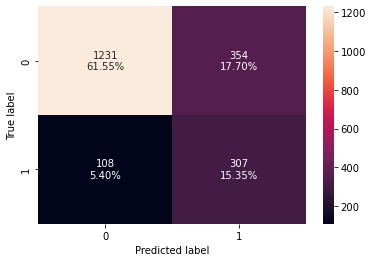

In [125]:
confusion_matrix_sklearn_with_threshold(best_hps, X_test, y_test,threshold=optimal_threshold(best_hps2))

In [126]:
best_hps2_train_perf = model_performance_classification_sklearn_with_threshold(
    best_hps2, X_train, y_train, threshold = optimal_threshold(best_hps2))
print("Training performance:")
best_hps2_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.765,0.82984,0.456271,0.588801,0.789175


In [127]:
best_hps2_test_perf = model_performance_classification_sklearn_with_threshold(
    best_hps2, X_test, y_test, threshold = optimal_threshold(best_hps2))
print("Test performance:")
best_hps2_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.759,0.792771,0.453793,0.577193,0.771464


As expected, it is not overfitting nearly as much. The Bayesian approach seems much better than the Hyperband approach in that regard. Otherwise, the results are very similar on the test set.

In [128]:
# Evaluate model on test set and add results to dataframe
bayesian = evaluate_model(best_hps2, X_test, y_test)

# Set index to 'Baseline'
bayesian.index = ['kt_bayesian']

# Display results
results = results.append(bayesian)

63/63 [==============================] - 0s 532us/step - loss: 0.4418 - tp: 304.0000 - fp: 312.0000 - tn: 1273.0000 - fn: 111.0000 - accuracy: 0.7885 - precision: 0.4935 - recall: 0.7325 - auc: 0.8550 - prc: 0.6878


## Initial Hypertuning Summary

In [129]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [base_model_test_perf.T,
     best_hps_test_perf.T,
     best_hps2_test_perf.T],
     axis=1,)


models_test_comp_df.columns = [
    "Baseline Model",
    "Hyperband",
    "Bayesian"]
print("Testing performance comparison:")

models_test_comp_df.T

Testing performance comparison:


,Accuracy,Recall,Precision,F1,AUC
Baseline Model,0.770,0.759036,0.466667,0.577982,0.765953
Hyperband,0.825,0.681928,0.564870,0.617904,0.772194
Bayesian,0.759,0.792771,0.453793,0.577193,0.771464


In [130]:
results

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698
kt_bayesian,0.441850,304.0,312.0,1273.0,111.0,0.7885,0.493506,0.732530,0.854952,0.687815


So far the basic Bayesian-tuned model is working well, with 0.856 auc. The recall is high without sacrificing all of our precision.

There is a bit of a difference between the sklearn scores, with sklearn saying the hyperband one is better. This has to do with how the thresholds are generated.

With Bayesian seemingly outperforming hyperband and with it taking A LOT less computation time, we're going to use it from now on.

Now, let's try tuning the feature set.

# Revisiting Feature Engineering

It occurs to me that we may be suffering from the curse of dimensionality. I think I will try feature reduction to see if we can't improve performance.

Ethnicity is a prime candidate for this. Almost all of its categories are useless. I'm going to try removing all but Muslim and Nordic, effectively making it "Muslim, Nordic, Other".

In [131]:
# Make a copy for this
df_simple = df.copy()

## Minus Most Ethnicities

In [132]:
# Pull up column indices so we know which to drop
df_simple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  float32
 1   Age                 10000 non-null  float32
 2   Tenure              10000 non-null  float32
 3   Balance             10000 non-null  float32
 4   NumOfProducts       10000 non-null  float32
 5   HasCrCard           10000 non-null  float32
 6   IsActiveMember      10000 non-null  float32
 7   EstimatedSalary     10000 non-null  float32
 8   Exited              10000 non-null  float32
 9   France              10000 non-null  float32
 10  Germany             10000 non-null  float32
 11  Spain               10000 non-null  float32
 12  Female              10000 non-null  float32
 13  Male                10000 non-null  float32
 14  Africans            10000 non-null  float32
 15  British             10000 non-null  float32
 16  EastA

In [133]:
# Dropping most ethnicities. Keeping Nordic and Muslim.
for column in df_simple.columns[14:25]:
    df_simple.drop([column],axis=1,inplace=True)

### Splitting the Data

In [134]:
# Specify the data 
X = df_simple.drop(columns="Exited")

y = df_simple["Exited"]

In [135]:
# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

### Scaling the Data

We want to scale all of the data so that our predictions are not dominated by high value features like salary. We only fit the scaler to X_train so that it doesn't peek at the test data.

In [136]:
# Define the scaler
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [137]:
print(f'X_train shape{X_train.shape}')
print(f'X_test shape{X_test.shape}')
print(f'y_train shape{y_train.shape}')
print(f'y_test shape{y_test.shape}')

X_train shape(8000, 15)
X_test shape(2000, 15)
y_train shape(8000,)
y_test shape(2000,)


In [138]:
# We messed with the data, so I want to re-set the class_weights, 
# though it should be about the same.
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6271558482282847, 1: 2.466091245376079}

### Building a Baseline Model

Before we hypertune we always want to make a baseline model with that dataset, that way we know if the hypertuning is actually helping.

In [139]:
#initialize the model
base_ethnic_model = Sequential()

# Add the first hidden layer/input layer
base_ethnic_model.add(Dense(units=15, input_dim = 15,activation='relu')) #input_dim = 16 for 26 columns

# Add the final layer. We're classifying, so we want sigmoid.
base_ethnic_model.add(Dense(1,activation='sigmoid'))  # Only 1 is needed: We're doing binary classification

In [140]:
base_ethnic_model.compile(loss= tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=METRICS)
base_ethnic_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


This time the shape is only 15 because we only have 15 columns/features.

In [141]:
# Recording the history
base_ethnic_model_history = base_ethnic_model.fit(X_train,
                                    y_train,
                                    epochs=100, 
                                                  batch_size=500,verbose=0,
                                    validation_split=0.2,
                                                  class_weight=class_weights)

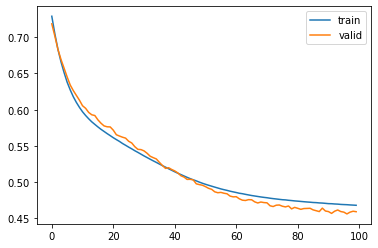

In [142]:
# Capturing learning history per epoch
hist  = pd.DataFrame(base_ethnic_model_history.history)
hist['epoch'] = base_ethnic_model_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


See, that's the kind of curve I expect. Well, except validation should also start high and go down.

Anyway, it converges pretty quickly. But, it keeps going down down down, so why not use a high epoch for this one?

In [143]:
# Fit the model
base_ethnic_model.fit(X_train, y_train,
                      epochs=100, batch_size=500,verbose=0, validation_split=0.2,
                      class_weight=class_weights) 

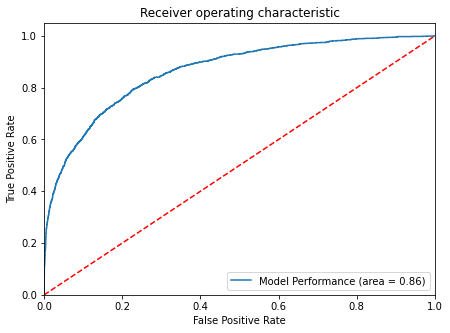

In [144]:
# Plot the curve
AUC_ROC_Plot(base_ethnic_model)

In [145]:
# Get the optimal threshold
optimal_threshold(base_ethnic_model)

0.47594866

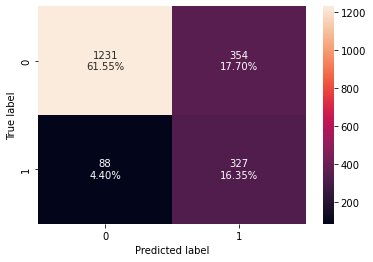

In [146]:
confusion_matrix_sklearn_with_threshold(base_ethnic_model, X_test, y_test,
                                        threshold=optimal_threshold(base_ethnic_model))

In [147]:
base_ethnic_model_train_perf = model_performance_classification_sklearn_with_threshold(
    base_ethnic_model, X_train, y_train, threshold = optimal_threshold(base_ethnic_model))
print("Training performance:")
base_ethnic_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.771125,0.797781,0.462639,0.585653,0.781063


In [148]:
base_ethnic_model_test_perf = model_performance_classification_sklearn_with_threshold(
    base_ethnic_model, X_test, y_test, threshold = optimal_threshold(base_ethnic_model))
print("Test performance:")
base_ethnic_model_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.779,0.787952,0.480176,0.596715,0.782304


The training set did worse than the test set. Go figure. Well, I'm not going to complain. It seems like dimension reduction really helped boost our scores.

In [149]:
# Evaluate model on test set and add results to dataframe
base_ethnic = evaluate_model(base_ethnic_model, X_test, y_test)

# Set index to 'Baseline'
base_ethnic.index = ['base_ethnic']

# Display results
results = results.append(base_ethnic)

63/63 [==============================] - 0s 549us/step - loss: 0.4471 - tp: 316.0000 - fp: 324.0000 - tn: 1261.0000 - fn: 99.0000 - accuracy: 0.7885 - precision: 0.4938 - recall: 0.7614 - auc: 0.8638 - prc: 0.7017


In [150]:
results

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698
kt_bayesian,0.441850,304.0,312.0,1273.0,111.0,0.7885,0.493506,0.732530,0.854952,0.687815
base_ethnic,0.447067,316.0,324.0,1261.0,99.0,0.7885,0.493750,0.761446,0.863760,0.701713


Quite a good performance thus far with improvements across the board. I bet hypertuning will help. We're just going to use Bayesian this time.

### Bayesian Hypertuning of the Simple Ethnic Model

In [151]:
# Initialize the tuner
tuner3 = kt.BayesianOptimization(build_model,
                                 objective=kt.Objective("val_auc", direction="max"),
                                 max_trials=30,
                                 project_name='Bayesian_Ethnic_weighted_regular')

INFO:tensorflow:Reloading Oracle from existing project .\Bayesian_Ethnic_weighted_regular\oracle.json
INFO:tensorflow:Reloading Tuner from .\Bayesian_Ethnic_weighted_regular\tuner0.json


In [152]:
# Display search space summary
tuner3.search_space_summary()

Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
L1 Regularizer (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.05, 'step': 0.01, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_3 (Flo

In [153]:
# Conduct the search with an early stop if it stalls out.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner3.search(X_train,
              y_train,
              epochs=NUM_EPOCHS,
              validation_split=0.2,
              callbacks=[stop_early],
              verbose=2,
              class_weight=class_weights)

INFO:tensorflow:Oracle triggered exit


In [154]:
# Get the optimal hyperparameters from the results
base_ethnic_model2 = tuner3.get_best_models()[0]
base_ethnic_model2.build(X_train.shape)
base_ethnic_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (8000, 15)                0         
_________________________________________________________________
dense (Dense)                (8000, 512)               8192      
_________________________________________________________________
dropout (Dropout)            (8000, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (8000, 32)                16416     
_________________________________________________________________
dropout_1 (Dropout)          (8000, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (8000, 512)               16896     
_________________________________________________________________
dropout_2 (Dropout)          (8000, 512)               0

That's a huge network. I'll have to be wary of overfitting.

In [155]:
# Recording the history
base_ethnic_model2_history = base_ethnic_model2.fit(X_train,
                                    y_train,
                                    epochs=20, batch_size=500,verbose=0,
                                    validation_split=0.2,
                                                   class_weight=class_weights)

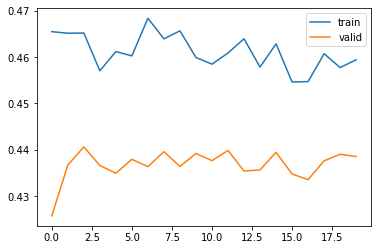

In [156]:
# Capturing learning history per epoch
hist  = pd.DataFrame(base_ethnic_model2_history.history)
hist['epoch'] = base_ethnic_model2_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


It looks like there is a pinch around 5 epochs, so I'll use that. I don't want to go higher because I am wary of overfitting

In [157]:
base_ethnic_model2.fit(X_train,y_train,epochs = 5, batch_size = 500, class_weight=class_weights)

Epoch 1/5
16/16 [==============================] - 1s 7ms/step - loss: 0.4605 - tp: 1239.0000 - fp: 1193.0000 - tn: 5185.0000 - fn: 383.0000 - accuracy: 0.8030 - precision: 0.5095 - recall: 0.7639 - auc: 0.8635 - prc: 0.6798
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.4592 - tp: 1246.0000 - fp: 1194.0000 - tn: 5184.0000 - fn: 376.0000 - accuracy: 0.8037 - precision: 0.5107 - recall: 0.7682 - auc: 0.8646 - prc: 0.6817
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.4641 - tp: 1236.0000 - fp: 1231.0000 - tn: 5147.0000 - fn: 386.0000 - accuracy: 0.7979 - precision: 0.5010 - recall: 0.7620 - auc: 0.8637 - prc: 0.6736
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.4628 - tp: 1243.0000 - fp: 1171.0000 - tn: 5207.0000 - fn: 379.0000 - accuracy: 0.8062 - precision: 0.5149 - recall: 0.7663 - auc: 0.8639 - prc: 0.6784
Epoch 5/5
16/16 [==============================] - 0s 7ms/step - loss: 0.4630 - tp: 1234.0000 - fp: 

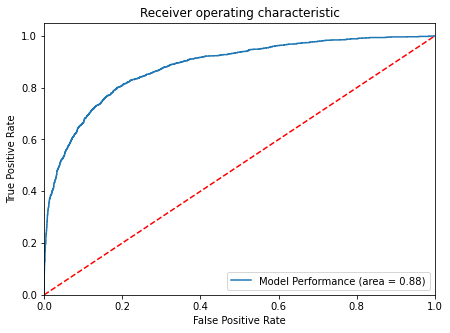

In [158]:
AUC_ROC_Plot(base_ethnic_model2)

In [159]:
optimal_threshold(base_ethnic_model2)

0.53560257

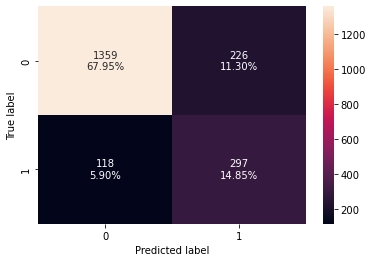

In [160]:
confusion_matrix_sklearn_with_threshold(base_ethnic_model2, X_test, y_test,
                                        threshold=optimal_threshold(base_ethnic_model2))

In [161]:
base_ethnic_model2_train_perf = model_performance_classification_sklearn_with_threshold(
    base_ethnic_model2, X_train, y_train, threshold = optimal_threshold(base_ethnic_model2))
print("Training performance:")
base_ethnic_model2_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.828125,0.760173,0.555656,0.64202,0.802789


In [162]:
base_ethnic_model2_test_perf = model_performance_classification_sklearn_with_threshold(
    base_ethnic_model2, X_test, y_test, threshold = optimal_threshold(base_ethnic_model2))
print("Test performance:")
base_ethnic_model2_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.828,0.715663,0.567878,0.633262,0.786538


In [163]:
# Evaluate model on test set and add results to dataframe
bayesian_ethnic = evaluate_model(base_ethnic_model2, X_test, y_test)

# Set index to 'Baseline'
bayesian_ethnic.index = ['Ethnic_Bayesian']

# Display results
results = results.append(bayesian_ethnic)

63/63 [==============================] - 0s 791us/step - loss: 0.4311 - tp: 306.0000 - fp: 270.0000 - tn: 1315.0000 - fn: 109.0000 - accuracy: 0.8105 - precision: 0.5312 - recall: 0.7373 - auc: 0.8701 - prc: 0.7163


In [164]:
results

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698
kt_bayesian,0.441850,304.0,312.0,1273.0,111.0,0.7885,0.493506,0.732530,0.854952,0.687815
base_ethnic,0.447067,316.0,324.0,1261.0,99.0,0.7885,0.493750,0.761446,0.863760,0.701713
Ethnic_Bayesian,0.431069,306.0,270.0,1315.0,109.0,0.8105,0.531250,0.737349,0.870078,0.716272


That worked wonderfully. I wonder if eliminating the other unimportant features would help? Let's try it.

## X-Treme Dimensionality Reduction

In [165]:
df_simple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  float32
 1   Age              10000 non-null  float32
 2   Tenure           10000 non-null  float32
 3   Balance          10000 non-null  float32
 4   NumOfProducts    10000 non-null  float32
 5   HasCrCard        10000 non-null  float32
 6   IsActiveMember   10000 non-null  float32
 7   EstimatedSalary  10000 non-null  float32
 8   Exited           10000 non-null  float32
 9   France           10000 non-null  float32
 10  Germany          10000 non-null  float32
 11  Spain            10000 non-null  float32
 12  Female           10000 non-null  float32
 13  Male             10000 non-null  float32
 14  Muslim           10000 non-null  float32
 15  Nordic           10000 non-null  float32
dtypes: float32(16)
memory usage: 625.1 KB


As a reminder, the following columns were deemed unimportant by our EDA:
* CreditScore
* HasCrCard
* EstimatedSalary

Let's cut it down and see if things improve even more.

In [166]:
# Making a new df
df_slim = df_simple.copy()

In [167]:
unimportant_columns = ['CreditScore', 'HasCrCard', 'EstimatedSalary']
for column in unimportant_columns:
    df_slim.drop([column],axis=1,inplace=True)

In [168]:
df_slim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             10000 non-null  float32
 1   Tenure          10000 non-null  float32
 2   Balance         10000 non-null  float32
 3   NumOfProducts   10000 non-null  float32
 4   IsActiveMember  10000 non-null  float32
 5   Exited          10000 non-null  float32
 6   France          10000 non-null  float32
 7   Germany         10000 non-null  float32
 8   Spain           10000 non-null  float32
 9   Female          10000 non-null  float32
 10  Male            10000 non-null  float32
 11  Muslim          10000 non-null  float32
 12  Nordic          10000 non-null  float32
dtypes: float32(13)
memory usage: 507.9 KB


### Splitting the Data

In [169]:
# Specify the data 
X = df_slim.drop(columns="Exited")

y = df_slim["Exited"]

In [170]:
# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)


### Scaling the Data

We want to scale all of the data so that our predictions are not dominated by high value features like salary. We only fit the scaler to X_train so that it doesn't peek at the test data.

In [171]:
# Define the scaler
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [172]:
print(f'X_train shape{X_train.shape}')
print(f'X_test shape{X_test.shape}')
print(f'y_train shape{y_train.shape}')
print(f'y_test shape{y_test.shape}')

X_train shape(8000, 12)
X_test shape(2000, 12)
y_train shape(8000,)
y_test shape(2000,)


In [173]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6271558482282847, 1: 2.466091245376079}

### Building a Baseline Model

In [174]:
#initialize the model
base_slim_model = Sequential()

# Add the first hidden layer/input layer
base_slim_model.add(Dense(units=12, input_dim = 12,activation='relu')) #input_dim = 16 for 26 columns

# Add the final layer. We're classifying, so we want sigmoid.
base_slim_model.add(Dense(1,activation='sigmoid'))  # Only 1 is needed: We're doing binary classification

In [175]:
base_slim_model.compile(loss= tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=METRICS)
base_slim_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


Only 12 nodes this time for our even slimmer dataset.

In [176]:
# Recording the history
base_slim_model_history = base_slim_model.fit(X_train,
                                    y_train,
                                    epochs=50, batch_size=500,verbose=0,
                                    validation_split=0.2,
                                             class_weight=class_weights)

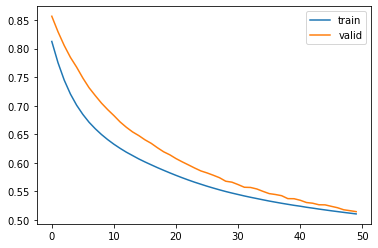

In [177]:
# Capturing learning history per epoch
hist  = pd.DataFrame(base_slim_model_history.history)
hist['epoch'] = base_slim_model_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


That seems fine. It starts to taper off around 20, so we'll use that.

In [178]:
base_slim_model.fit(X_train, y_train, epochs=20, batch_size=500,verbose=1, 
                    validation_split=0.2,
                    class_weight=class_weights) 

Epoch 1/20
13/13 [==============================] - 0s 3ms/step - loss: 0.5095 - tp: 988.0000 - fp: 1334.0000 - tn: 3768.0000 - fn: 310.0000 - accuracy: 0.7431 - precision: 0.4255 - recall: 0.7612 - auc: 0.8329 - prc: 0.5837 - val_loss: 0.5149 - val_tp: 242.0000 - val_fp: 310.0000 - val_tn: 966.0000 - val_fn: 82.0000 - val_accuracy: 0.7550 - val_precision: 0.4384 - val_recall: 0.7469 - val_auc: 0.8346 - val_prc: 0.5891
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.5083 - tp: 985.0000 - fp: 1317.0000 - tn: 3785.0000 - fn: 313.0000 - accuracy: 0.7453 - precision: 0.4279 - recall: 0.7589 - auc: 0.8335 - prc: 0.5857 - val_loss: 0.5103 - val_tp: 241.0000 - val_fp: 305.0000 - val_tn: 971.0000 - val_fn: 83.0000 - val_accuracy: 0.7575 - val_precision: 0.4414 - val_recall: 0.7438 - val_auc: 0.8356 - val_prc: 0.5927
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.5070 - tp: 983.0000 - fp: 1314.0000 - tn: 3788.0000 - fn: 315.0000 - accuracy: 0

That's absolutely horrible performance. We can do better than that. It's just classifying absolutely everything as positive.

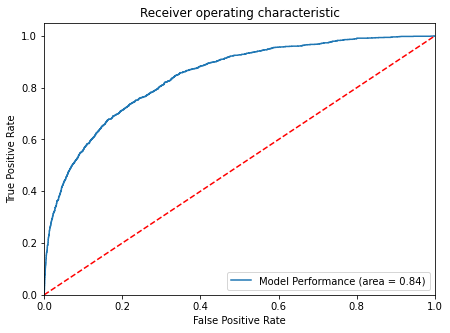

In [179]:
# Plot the ROC curve
AUC_ROC_Plot(base_slim_model)

In [180]:
# Get the threshold
optimal_threshold(base_slim_model)

0.5225278

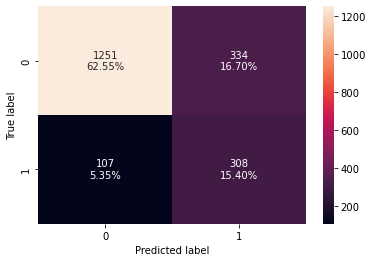

In [181]:
confusion_matrix_sklearn_with_threshold(base_slim_model, X_test, y_test,
                                        threshold=optimal_threshold(base_slim_model))

In [182]:
base_slim_model_train_perf = model_performance_classification_sklearn_with_threshold(
    base_slim_model, X_train, y_train, threshold = optimal_threshold(base_slim_model))
print("Training performance:")
base_slim_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.771875,0.734895,0.460765,0.566405,0.758087


In [183]:
base_slim_model_test_perf = model_performance_classification_sklearn_with_threshold(
    base_slim_model, X_test, y_test, threshold = optimal_threshold(base_slim_model))
print("Test performance:")
base_slim_model_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.7795,0.742169,0.479751,0.582781,0.765722


In [184]:
# Evaluate model on test set and add results to dataframe
base_slim = evaluate_model(base_slim_model, X_test, y_test)

# Set index to 'Baseline'
base_slim.index = ['base_slim']

# Display results
results = results.append(base_slim)

63/63 [==============================] - 0s 549us/step - loss: 0.4883 - tp: 314.0000 - fp: 364.0000 - tn: 1221.0000 - fn: 101.0000 - accuracy: 0.7675 - precision: 0.4631 - recall: 0.7566 - auc: 0.8425 - prc: 0.6417


In [185]:
results

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698
kt_bayesian,0.441850,304.0,312.0,1273.0,111.0,0.7885,0.493506,0.732530,0.854952,0.687815
base_ethnic,0.447067,316.0,324.0,1261.0,99.0,0.7885,0.493750,0.761446,0.863760,0.701713
Ethnic_Bayesian,0.431069,306.0,270.0,1315.0,109.0,0.8105,0.531250,0.737349,0.870078,0.716272
base_slim,0.488271,314.0,364.0,1221.0,101.0,0.7675,0.463127,0.756626,0.842488,0.641697


It'not an improvement yet, but it still has a solid turnout. Let's see if tuning it will bump it up even higher.

### Bayesian Hypertuning of the Simple Slim Model

In [186]:
# Define the tuner
tuner4 = kt.BayesianOptimization(build_model,
                                 objective=kt.Objective("val_auc", direction="max"),
                                 max_trials=30,
                                 project_name='Slim_Bayesian_weighted_regular')

INFO:tensorflow:Reloading Oracle from existing project .\Slim_Bayesian_weighted_regular\oracle.json
INFO:tensorflow:Reloading Tuner from .\Slim_Bayesian_weighted_regular\tuner0.json


In [187]:
# Display search space summary
tuner4.search_space_summary()

Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
L1 Regularizer (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.05, 'step': 0.01, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_3 (Flo

In [188]:
# Conduct the search with an early stop.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner4.search(X_train,
              y_train,
              epochs=NUM_EPOCHS,
              validation_split=0.2,
              callbacks=[stop_early],
              verbose=2,
              class_weight=class_weights)

INFO:tensorflow:Oracle triggered exit


In [189]:
# Get the optimal hyperparameters from the results
base_slim_model2 = tuner4.get_best_models()[0]
base_slim_model2.build(X_train.shape)
base_slim_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (8000, 12)                0         
_________________________________________________________________
dense (Dense)                (8000, 512)               6656      
_________________________________________________________________
dropout (Dropout)            (8000, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (8000, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (8000, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (8000, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (8000, 512)               0

In [190]:
base_slim_model2_history = base_slim_model2.fit(X_train,
                                    y_train,
                                    epochs=20, batch_size=500,verbose=0,
                                    validation_split=0.2,
                                               class_weight=class_weights)

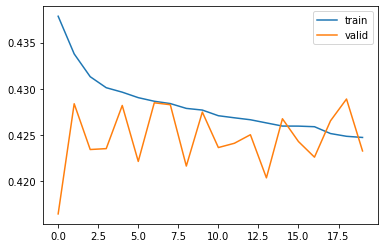

In [191]:
# Capturing learning history per epoch
hist  = pd.DataFrame(base_slim_model2_history.history)
hist['epoch'] = base_slim_model2_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


Again it is not as bad as it looks as it is bouncing around within a very small range. Even so, I don't want to overfit, so just a small number of epochs is fine.

In [192]:
base_slim_model2.fit(X_train,y_train,epochs = 3, batch_size = 500, class_weight=class_weights)

Epoch 1/3
16/16 [==============================] - 1s 9ms/step - loss: 0.4304 - tp: 1252.0000 - fp: 1187.0000 - tn: 5191.0000 - fn: 370.0000 - accuracy: 0.8054 - precision: 0.5133 - recall: 0.7719 - auc: 0.8811 - prc: 0.7248
Epoch 2/3
16/16 [==============================] - 0s 9ms/step - loss: 0.4297 - tp: 1264.0000 - fp: 1221.0000 - tn: 5157.0000 - fn: 358.0000 - accuracy: 0.8026 - precision: 0.5087 - recall: 0.7793 - auc: 0.8815 - prc: 0.7254
Epoch 3/3
16/16 [==============================] - 0s 8ms/step - loss: 0.4293 - tp: 1276.0000 - fp: 1260.0000 - tn: 5118.0000 - fn: 346.0000 - accuracy: 0.7993 - precision: 0.5032 - recall: 0.7867 - auc: 0.8818 - prc: 0.7252


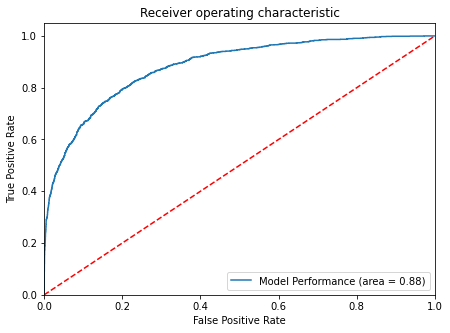

In [193]:
# Plotting AUC
AUC_ROC_Plot(base_slim_model2)

In [194]:
# Getting the threshold
optimal_threshold(base_slim_model2)

0.5807607

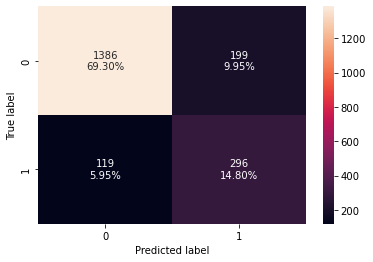

In [195]:
confusion_matrix_sklearn_with_threshold(base_slim_model2, X_test, y_test,
                                        threshold=optimal_threshold(base_slim_model2))

In [196]:
base_slim_model2_train_perf = model_performance_classification_sklearn_with_threshold(
    base_slim_model2, X_train, y_train, threshold = optimal_threshold(base_slim_model2))
print("Training performance:")
base_slim_model2_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.83575,0.710851,0.577077,0.637017,0.789182


In [197]:
base_slim_model2_test_perf = model_performance_classification_sklearn_with_threshold(
    base_slim_model2, X_test, y_test, threshold = optimal_threshold(base_slim_model2))
print("Test performance:")
base_slim_model2_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.841,0.713253,0.59798,0.650549,0.79385


In [198]:
# Evaluate model on test set and add results to dataframe
bayesian_slim = evaluate_model(base_slim_model2, X_test, y_test)

# Set index to 'Baseline'
bayesian_slim.index = ['Slim_Bayesian']

# Display results
results = results.append(bayesian_slim)

63/63 [==============================] - 0s 1ms/step - loss: 0.4250 - tp: 314.0000 - fp: 287.0000 - tn: 1298.0000 - fn: 101.0000 - accuracy: 0.8060 - precision: 0.5225 - recall: 0.7566 - auc: 0.8724 - prc: 0.7247


In [199]:
results

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698
kt_bayesian,0.441850,304.0,312.0,1273.0,111.0,0.7885,0.493506,0.732530,0.854952,0.687815
base_ethnic,0.447067,316.0,324.0,1261.0,99.0,0.7885,0.493750,0.761446,0.863760,0.701713
Ethnic_Bayesian,0.431069,306.0,270.0,1315.0,109.0,0.8105,0.531250,0.737349,0.870078,0.716272
base_slim,0.488271,314.0,364.0,1221.0,101.0,0.7675,0.463127,0.756626,0.842488,0.641697
Slim_Bayesian,0.425014,314.0,287.0,1298.0,101.0,0.8060,0.522463,0.756626,0.872372,0.724651


We have seen huge success removing dimensions. There was a lot of noise in the data that we eliminated. The slim Bayesian hypertuned model is clearly the winner according to sklearn's judgment, and still the winner in terms of best auc according to model.evaluate.

## Dimensionality Reduction Summary

In [200]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [base_model_test_perf.T,
     best_hps_test_perf.T,
     best_hps2_test_perf.T,
     base_ethnic_model_test_perf.T,
     base_ethnic_model2_test_perf.T,
     base_slim_model_test_perf.T,
     base_slim_model2_test_perf.T],
     axis=1,)


models_test_comp_df.columns = [
    "Baseline Model",
    "Hyperband",
    "Bayesian",
    "Base Ethnic",
    "Ethnic Bayesian",
    "Base Slim",
    "Slim Bayesian"]
print("Testing performance comparison:")

models_test_comp_df.T

Testing performance comparison:


,Accuracy,Recall,Precision,F1,AUC
Baseline Model,0.7700,0.759036,0.466667,0.577982,0.765953
Hyperband,0.8250,0.681928,0.564870,0.617904,0.772194
Bayesian,0.7590,0.792771,0.453793,0.577193,0.771464
Base Ethnic,0.7790,0.787952,0.480176,0.596715,0.782304
Ethnic Bayesian,0.8280,0.715663,0.567878,0.633262,0.786538
Base Slim,0.7795,0.742169,0.479751,0.582781,0.765722
Slim Bayesian,0.8410,0.713253,0.597980,0.650549,0.793850


Trimming the fat really made huge improvements to our model's performance. With a .844 accuracy and 0.79 auc I'd say we're doing pretty well. I've seen research papers only yield .85 on bank customer churn, so I'm pretty happy.

However, there was another idea for feature engineering: turning balance into a binary category.

## Zero Balance

I also thought perhaps turning balance into a category of zero or not zero would improve things. I am encouraged that simplifying everything seems to continually bring improvements, and so I think I'll give this a try.

In [201]:
# Making a new df
df_balanced = df_slim.copy()
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             10000 non-null  float32
 1   Tenure          10000 non-null  float32
 2   Balance         10000 non-null  float32
 3   NumOfProducts   10000 non-null  float32
 4   IsActiveMember  10000 non-null  float32
 5   Exited          10000 non-null  float32
 6   France          10000 non-null  float32
 7   Germany         10000 non-null  float32
 8   Spain           10000 non-null  float32
 9   Female          10000 non-null  float32
 10  Male            10000 non-null  float32
 11  Muslim          10000 non-null  float32
 12  Nordic          10000 non-null  float32
dtypes: float32(13)
memory usage: 507.9 KB


In [202]:
# Turning Balance into a binary category of has 0 balance or has more than 0.
for i, row in df_balanced.iterrows():
    if df_balanced.at[i,'Balance'] == 0:
        df_balanced.at[i,'Balance_cat'] = 0
    else:
        df_balanced.at[i,'Balance_cat'] = 1
df_balanced['Balance_cat'].value_counts()

1.0    6383
0.0    3617
Name: Balance_cat, dtype: int64

Before we drop the original, I want to see how much information we're really losing. I'm going to analyze just those without 0.

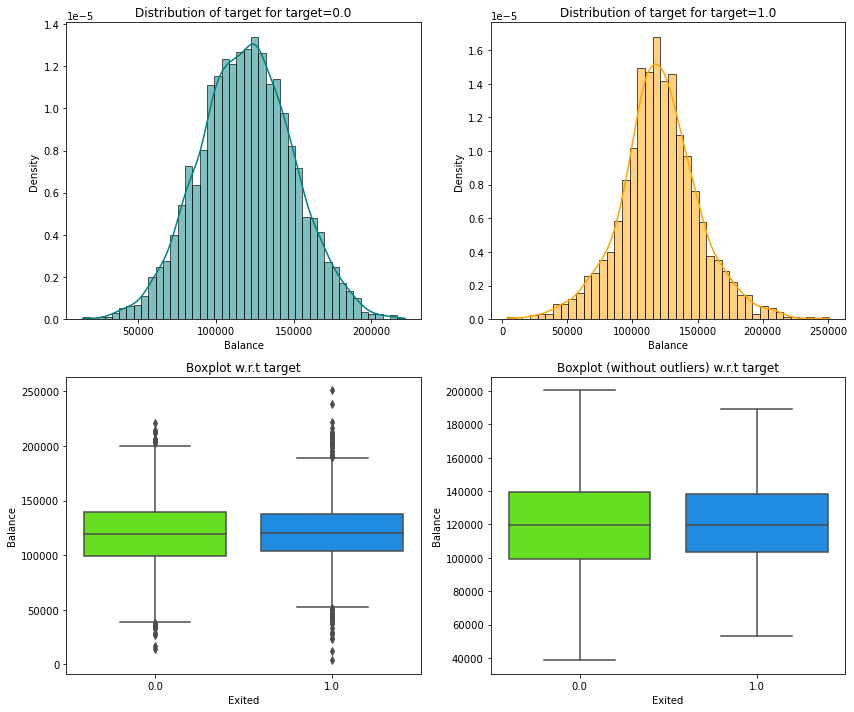

In [203]:
# Separating out those with above 0 balances and seeing how it interacts with exit
balanced = df_balanced[(df_balanced['Balance_cat'] == 1)]
distribution_plot_wrt_target(balanced, "Balance", "Exited")

As we can see from the above, without the zeroes these two curves are almost identical. There is only a very slight difference at the edges. We shouldn't lose much. Likewise, let's look at the zeroes.

Exited        0.0   1.0    All
Balance_cat                   
All          7963  2037  10000
1.0          4846  1537   6383
0.0          3117   500   3617
------------------------------------------------------------------------------------------------------------------------


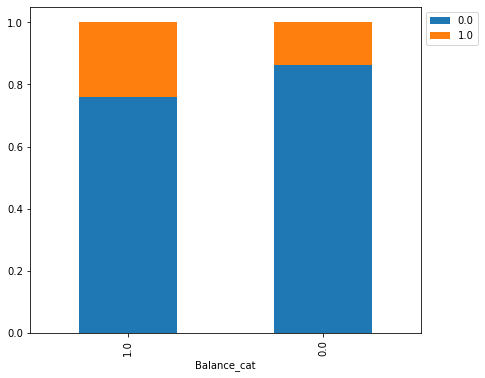

In [204]:
stacked_barplot(df_balanced, "Balance_cat", "Exited")

That's a fairly big difference, all things considered. Let's go ahead and test this in a model.

In [205]:
# Dropping the original now that we have the category
df_balanced.drop(['Balance'], axis=1, inplace=True)

### Splitting the Data

In [206]:
# Specify the data 
X = df_balanced.drop(columns="Exited")

y = df_balanced["Exited"]

In [207]:
y.value_counts()

0.0    7963
1.0    2037
Name: Exited, dtype: int64

In [208]:
# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)


### Scaling the Data

We want to scale all of the data so that our predictions are not dominated by high value features like salary. We only fit the scaler to X_train so that it doesn't peek at the test data.

In [209]:
# Define the scaler
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [210]:
print(f'X_train shape{X_train.shape}')
print(f'X_test shape{X_test.shape}')
print(f'y_train shape{y_train.shape}')
print(f'y_test shape{y_test.shape}')

X_train shape(8000, 12)
X_test shape(2000, 12)
y_train shape(8000,)
y_test shape(2000,)


In [211]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6271558482282847, 1: 2.466091245376079}

### Building a Baseline Model

In [212]:
#initialize the model
balance_model = Sequential()

# Add the first hidden layer/input layer
balance_model.add(Dense(units=12, input_dim = 12,activation='relu')) #input_dim = 16 for 26 columns

# Add the final layer. We're classifying, so we want sigmoid.
balance_model.add(Dense(1,activation='sigmoid'))  # Only 1 is needed: We're doing binary classification

In [213]:
balance_model.compile(loss= tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=METRICS)
balance_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [214]:
# Recording the history
balance_model_history = balance_model.fit(X_train,
                                    y_train,
                                    epochs=20, batch_size=500,verbose=0,
                                    validation_split=0.2,
                                         class_weight=class_weights)

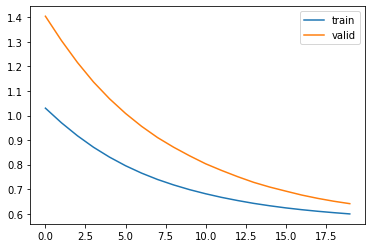

In [215]:
# Capturing learning history per epoch
hist  = pd.DataFrame(balance_model_history.history)
hist['epoch'] = balance_model_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


In [216]:
balance_model.fit(X_train, y_train, epochs=60, batch_size=500,
                  verbose=0, validation_split=0.2,
                  class_weight=class_weights) 

That's absolutely horrible performance. We can do better than that. It's just classifying absolutely everything as positive.

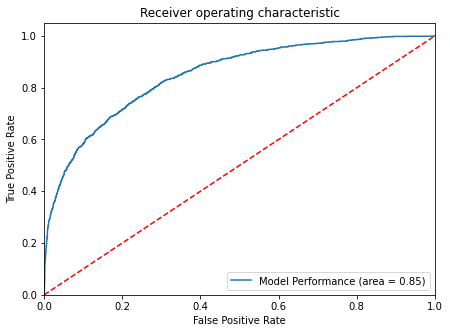

In [217]:
AUC_ROC_Plot(balance_model)

In [218]:
optimal_threshold(balance_model)

0.51440346

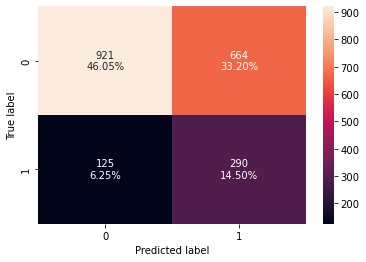

In [219]:
confusion_matrix_sklearn_with_threshold(base_slim_model, X_test, y_test,
                                        threshold=optimal_threshold(balance_model))

In [220]:
balance_model_train_perf = model_performance_classification_sklearn_with_threshold(
    balance_model, X_train, y_train, threshold = optimal_threshold(balance_model))
print("Training performance:")
balance_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.776875,0.729963,0.467799,0.57019,0.759384


In [221]:
balance_model_test_perf = model_performance_classification_sklearn_with_threshold(
    balance_model, X_test, y_test, threshold = optimal_threshold(balance_model))
print("Test performance:")
balance_model_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.7955,0.751807,0.504854,0.604066,0.779374


In [222]:
# Evaluate model on test set and add results to dataframe
base_balance = evaluate_model(balance_model, X_test, y_test)

# Set index to 'Baseline'
base_balance.index = ['base_balance']

# Display results
results = results.append(base_balance)

63/63 [==============================] - 0s 549us/step - loss: 0.4737 - tp: 316.0000 - fp: 325.0000 - tn: 1260.0000 - fn: 99.0000 - accuracy: 0.7880 - precision: 0.4930 - recall: 0.7614 - auc: 0.8536 - prc: 0.6737


In [223]:
results

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698
kt_bayesian,0.441850,304.0,312.0,1273.0,111.0,0.7885,0.493506,0.732530,0.854952,0.687815
base_ethnic,0.447067,316.0,324.0,1261.0,99.0,0.7885,0.493750,0.761446,0.863760,0.701713
Ethnic_Bayesian,0.431069,306.0,270.0,1315.0,109.0,0.8105,0.531250,0.737349,0.870078,0.716272
base_slim,0.488271,314.0,364.0,1221.0,101.0,0.7675,0.463127,0.756626,0.842488,0.641697
Slim_Bayesian,0.425014,314.0,287.0,1298.0,101.0,0.8060,0.522463,0.756626,0.872372,0.724651
base_balance,0.473687,316.0,325.0,1260.0,99.0,0.7880,0.492980,0.761446,0.853614,0.673698


It is worse in every regard to the more complicated model. Even so, let's try hypertuning it. We'll only use Bayesian for it, since that worked best before.

### Bayesian Hypertuning of the Simple Slim Model

In [224]:
tuner5 = kt.BayesianOptimization(build_model,
                                 objective=kt.Objective("val_auc", direction="max"),
                                 max_trials=30,
                                 project_name='balance_model_weighted_regular')

INFO:tensorflow:Reloading Oracle from existing project .\balance_model_weighted_regular\oracle.json
INFO:tensorflow:Reloading Tuner from .\balance_model_weighted_regular\tuner0.json


In [225]:
# Display search space summary
tuner5.search_space_summary()

Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
L1 Regularizer (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.05, 'step': 0.01, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_3 (Flo

In [226]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner5.search(X_train,
              y_train,
              epochs=NUM_EPOCHS,
              validation_split=0.2,
              callbacks=[stop_early],
              verbose=2,
              class_weight=class_weights)

INFO:tensorflow:Oracle triggered exit


In [227]:
# Get the optimal hyperparameters from the results
balance_model2 = tuner5.get_best_models()[0]
balance_model2.build(X_train.shape)
balance_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (8000, 12)                0         
_________________________________________________________________
dense (Dense)                (8000, 512)               6656      
_________________________________________________________________
dropout (Dropout)            (8000, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (8000, 1)                 513       
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________


That went to 6 layers, which was the cap. I wonder if we could get more by going beyond that. I'll try it before moving on. To do this I'll have to change our function.

In [228]:
def build_model_oversix(hp):
    """
    Builds model and sets up hyperparameter space to search.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten())

    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 6, 15)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=1, activation="sigmoid"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
    
    return model

In [229]:
tuner6 = kt.BayesianOptimization(build_model_oversix,
                                 objective=kt.Objective("val_auc", direction="max"),
                                 max_trials=30,
                                 project_name='oversix_balance_model_weighted_regular')

INFO:tensorflow:Reloading Oracle from existing project .\oversix_balance_model_weighted_regular\oracle.json
INFO:tensorflow:Reloading Tuner from .\oversix_balance_model_weighted_regular\tuner0.json


In [230]:
# Display search space summary
tuner6.search_space_summary()

Search space summary
Default search space size: 30
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 15, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_3 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_4 (Flo

In [231]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner6.search(X_train,
              y_train,
              epochs=NUM_EPOCHS,
              validation_split=0.2,
              callbacks=[stop_early],
              verbose=2,
              class_weight=class_weights)

INFO:tensorflow:Oracle triggered exit


In [232]:
# Get the optimal hyperparameters from the results
balance_model3 = tuner6.get_best_models()[0]
balance_model3.build(X_train.shape)
balance_model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (8000, 12)                0         
_________________________________________________________________
dense (Dense)                (8000, 416)               5408      
_________________________________________________________________
dropout (Dropout)            (8000, 416)               0         
_________________________________________________________________
dense_1 (Dense)              (8000, 224)               93408     
_________________________________________________________________
dropout_1 (Dropout)          (8000, 224)               0         
_________________________________________________________________
dense_2 (Dense)              (8000, 320)               72000     
_________________________________________________________________
dropout_2 (Dropout)          (8000, 320)               0

It got up to 12 layers, but it didn't surpass the 6 layer val_auc score. So, I'll go with the 6 layer one.

In [233]:
balance_model2_history = base_slim_model2.fit(X_train,
                                    y_train,
                                    epochs=20, batch_size=500,verbose=0,
                                    validation_split=0.2,
                                             class_weight=class_weights)

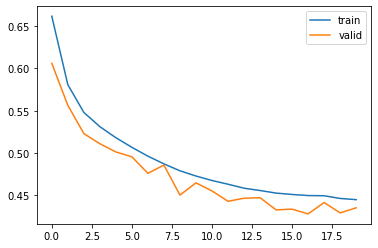

In [234]:
# Capturing learning history per epoch
hist  = pd.DataFrame(balance_model2_history.history)
hist['epoch'] = balance_model2_history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


In [235]:
balance_model2.fit(X_train,y_train,epochs = 15, batch_size = 500, class_weight=class_weights)

Epoch 1/15
16/16 [==============================] - 1s 1ms/step - loss: 0.4601 - tp: 1508.0000 - fp: 1693.0000 - tn: 5961.0000 - fn: 438.0000 - accuracy: 0.7780 - precision: 0.4711 - recall: 0.7749 - auc: 0.8623 - prc: 0.6891
Epoch 2/15
16/16 [==============================] - 0s 1ms/step - loss: 0.4536 - tp: 1215.0000 - fp: 1231.0000 - tn: 5147.0000 - fn: 407.0000 - accuracy: 0.7952 - precision: 0.4967 - recall: 0.7491 - auc: 0.8669 - prc: 0.6983
Epoch 3/15
16/16 [==============================] - 0s 1ms/step - loss: 0.4489 - tp: 1235.0000 - fp: 1248.0000 - tn: 5130.0000 - fn: 387.0000 - accuracy: 0.7956 - precision: 0.4974 - recall: 0.7614 - auc: 0.8694 - prc: 0.7042
Epoch 4/15
16/16 [==============================] - 0s 1ms/step - loss: 0.4470 - tp: 1254.0000 - fp: 1288.0000 - tn: 5090.0000 - fn: 368.0000 - accuracy: 0.7930 - precision: 0.4933 - recall: 0.7731 - auc: 0.8705 - prc: 0.7067
Epoch 5/15
16/16 [==============================] - 0s 1ms/step - loss: 0.4453 - tp: 1230.0000 -

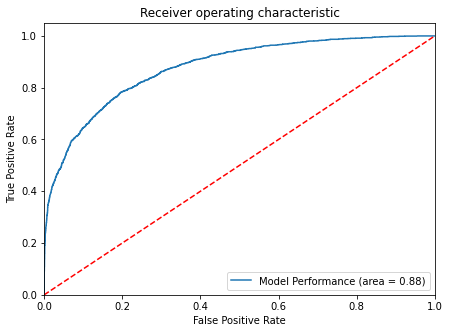

In [236]:
# Graph AUC
AUC_ROC_Plot(balance_model2)

In [237]:
# Get the best threshold
optimal_threshold(balance_model2)

0.61196774

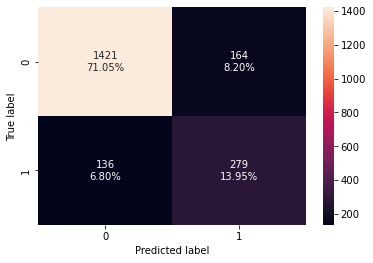

In [238]:
confusion_matrix_sklearn_with_threshold(balance_model2, X_test, y_test,
                                        threshold=optimal_threshold(balance_model2))

In [239]:
balance_model2_train_perf = model_performance_classification_sklearn_with_threshold(
    balance_model2, X_train, y_train, threshold = optimal_threshold(balance_model2))
print("Training performance:")
balance_model2_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.840875,0.666461,0.596249,0.629403,0.775846


In [240]:
balance_model2_test_perf = model_performance_classification_sklearn_with_threshold(
    balance_model2, X_test, y_test, threshold = optimal_threshold(balance_model2))
print("Test performance:")
balance_model2_test_perf

Test performance:


,Accuracy,Recall,Precision,F1,AUC
0,0.85,0.672289,0.629797,0.65035,0.78441


In [241]:
# Evaluate model on test set and add results to dataframe
balance_tuned = evaluate_model(balance_model2, X_test, y_test)

# Set index to 'Baseline'
balance_tuned.index = ['Balance_tuned']

# Display results
results = results.append(balance_tuned)

63/63 [==============================] - 1s 565us/step - loss: 0.4267 - tp: 309.0000 - fp: 296.0000 - tn: 1289.0000 - fn: 106.0000 - accuracy: 0.7990 - precision: 0.5107 - recall: 0.7446 - auc: 0.8704 - prc: 0.7229


In [242]:
results

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698
kt_bayesian,0.441850,304.0,312.0,1273.0,111.0,0.7885,0.493506,0.732530,0.854952,0.687815
base_ethnic,0.447067,316.0,324.0,1261.0,99.0,0.7885,0.493750,0.761446,0.863760,0.701713
Ethnic_Bayesian,0.431069,306.0,270.0,1315.0,109.0,0.8105,0.531250,0.737349,0.870078,0.716272
base_slim,0.488271,314.0,364.0,1221.0,101.0,0.7675,0.463127,0.756626,0.842488,0.641697
Slim_Bayesian,0.425014,314.0,287.0,1298.0,101.0,0.8060,0.522463,0.756626,0.872372,0.724651
base_balance,0.473687,316.0,325.0,1260.0,99.0,0.7880,0.492980,0.761446,0.853614,0.673698
Balance_tuned,0.426722,309.0,296.0,1289.0,106.0,0.7990,0.510744,0.744578,0.870428,0.722898


Pretty good, but not better than just our tuned slim model. It seems there was just enough variation in Balance for it to contribute more information than noise.

# Summary of All Results

In [243]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [base_model_test_perf.T,
     best_hps_test_perf.T,
     best_hps2_test_perf.T,
     base_ethnic_model_test_perf.T,
     base_ethnic_model2_test_perf.T,
     base_slim_model_test_perf.T,
     base_slim_model2_test_perf.T,
     balance_model_test_perf.T,
     balance_model2_test_perf.T],
     axis=1,)


models_test_comp_df.columns = [
    "Baseline Model",
    "Hyperband",
    "Bayesian",
    "Base Ethnic",
    "Ethnic Bayesian",
    "Base Slim",
    "Slim Bayesian",
    "Base Balance",
    "Balance Bayesian"]
print("Testing performance comparison:")

models_test_comp_df.T

Testing performance comparison:


,Accuracy,Recall,Precision,F1,AUC
Baseline Model,0.7700,0.759036,0.466667,0.577982,0.765953
Hyperband,0.8250,0.681928,0.564870,0.617904,0.772194
Bayesian,0.7590,0.792771,0.453793,0.577193,0.771464
Base Ethnic,0.7790,0.787952,0.480176,0.596715,0.782304
Ethnic Bayesian,0.8280,0.715663,0.567878,0.633262,0.786538
Base Slim,0.7795,0.742169,0.479751,0.582781,0.765722
Slim Bayesian,0.8410,0.713253,0.597980,0.650549,0.793850
Base Balance,0.7955,0.751807,0.504854,0.604066,0.779374
Balance Bayesian,0.8500,0.672289,0.629797,0.650350,0.784410


In [244]:
results

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
Baseline,0.486269,316.0,362.0,1223.0,99.0,0.7695,0.466077,0.761446,0.841655,0.645851
basic_model,0.442860,302.0,297.0,1288.0,113.0,0.7950,0.504174,0.727711,0.853616,0.685444
kt_hyperband,0.436964,296.0,283.0,1302.0,119.0,0.7990,0.511226,0.713253,0.842229,0.669698
kt_bayesian,0.441850,304.0,312.0,1273.0,111.0,0.7885,0.493506,0.732530,0.854952,0.687815
base_ethnic,0.447067,316.0,324.0,1261.0,99.0,0.7885,0.493750,0.761446,0.863760,0.701713
Ethnic_Bayesian,0.431069,306.0,270.0,1315.0,109.0,0.8105,0.531250,0.737349,0.870078,0.716272
base_slim,0.488271,314.0,364.0,1221.0,101.0,0.7675,0.463127,0.756626,0.842488,0.641697
Slim_Bayesian,0.425014,314.0,287.0,1298.0,101.0,0.8060,0.522463,0.756626,0.872372,0.724651
base_balance,0.473687,316.0,325.0,1260.0,99.0,0.7880,0.492980,0.761446,0.853614,0.673698
Balance_tuned,0.426722,309.0,296.0,1289.0,106.0,0.7990,0.510744,0.744578,0.870428,0.722898


## Score Discrepencies

First, it is important to note the discrepency between the scores. The models are the same in both cases, the difference is the thresholds set.

evaluate_model chooses its own threshold based on its own internal criteria. It is likely that it was prioritizing auc, as that is what we told it to maximize. Indeed, all of the AUC scores from evaluate_model are higher.

The sklearn threshold was set by us when we plotted the auc-roc and chose the optimal threshold value. In general, for whatever reason, this made the precision higher in exchange for a loss in AUC. Otherwise, I cannot offer detailed explanations for the differences because how the threshold is calculated in evaluate_model is opaque to me.

Regardless, the discrepency should not bother us all that much as the ranking of the models doesn't change.

Once again, we are primarily concerned with our ability to distinguish between the positive class and the negative class. That means we should be aiming for a high AUC score. 

## Best Model

The slim bayesian model, the model where I dropped all features the EDA identified as unimportant, is the best model in all categories according to sklearn, and it is the best model for our target metric AUC according to evaluate_model. 

## Conclusions

The drawback to using neural networks is that they are currently black boxes: We can't see which features are more important or in what direction they go. However, our hypertuning efforts elucidate a few key points: Namely, if dropping a feature improved the model, it was not useful in prediction. If a feature did not improve prediction, we can safely say it is not the cause of exit.

People may exit the bank for any number of reasons outside of our control. However, in order to continually improve our products we must assume the blame. At the very least, the following features deserve scrutiny by management to see if we can improve our customer experience in these areas. There is no particular order.

### Age
Older people tend to exit our bank. Why? The obvious answer, that they are dying, seems incorrect because the oldest people have the exact opposite trend: those over 70 almost never exit.

This implies some sort of dissatisfaction linked to age that is perhaps generational.

###  Balance

If the customer has zero balance they are more likely to stay, according to the EDA. This is disasterous. The bank wants people with more money to maintain people with high balances so that we can loan out their money to others, that's the whole point. This implies we are getting the exact opposite of what we want.

I suggest management take a careful look at the incentive structure of our bank: As balances get higher, exiting should go down. Because this is not the case, they are not receiving a strong enough incentive to stay.

### Number of Products

According to the EDA, if a customer has 2 products they are more likely to stay, but anything higher than that and they're almost guaranteed to exit within six months.

I hypothesize that this feature has more depth to it, and it deserves scrutiny. I would postulate that not all products are equal, and there are certain products that encourage retention more than others. Some of the products may be encouraging exiting because of poor performance or customer service.

I encourage management to separate NumOfProducts into their categories so that we can analyze each product separately.

Furthermore, I notice that whether or not the customer has a credit card has no bearing on how many products they have: Many customers with 4 products (the max) also do not have a credit card. This implies we do not offer our own credit card, or it is not included in the dataset. Why not? Other studies have shown that having a bank's card increases loyalty to that bank. It also gives us a lot of options for tweaking incentives for valuable customers.

### IsActiveMember

It should be a surprise to no one that inactive members are more likely to exit. However, this doesn't mean this area is not open for improvement. There are plenty of ways to make people more active that we can explore.

### Geography

Those living in Germany seem to exit at a substantially higher rate. This deserves close scrutiny: Perhaps our services are not competitive there?

### Gender

Not only are there fewer women customers than male ones, the female ones also exit at a higher rate. This implies there is some part of our service that is unappealing to women.

I suggest marketing surveys or focus groups to determine how to make our services appeal to women more.

### Ethnicity

Europe's demographics are changing. Huge numbers of migrants from North Africa and elsewhere have caused a surge in ethnic-Muslims entering the EU. Although a tiny sample of our customers were ethnic-Muslim, we ignore their higher exit rate at our own peril. Marketing should seek out these customers and try to discover their reasons for exit or retention, respectively.

# Final Word

Overall, we created a model that will predict who will exit or not at above a 80% accuracy, with a good ability to distinguish between those who will exit and those who will not.

We also found many insights for directions the bank can move to increase retention.